# №1. Задания по предварительному анализу. 
## Вариант 7

In [83]:
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette("Dark2"))
import numpy as np 
import pylab 
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

DATA_PATH='D:/FPMI-3 Учебное/САДЭ_ММАД/Практика/MyLabs/Labs2-4/data/'
path_d='D:/FPMI-3 Учебное/САДЭ_ММАД/Практика/MyLabs/Labs2-4/data/demo2017.sav'
path_h='D:/FPMI-3 Учебное/САДЭ_ММАД/Практика/MyLabs/Labs2-4/data/health2017.sav'
path_i='D:/FPMI-3 Учебное/САДЭ_ММАД/Практика/MyLabs/Labs2-4/data/income2017.sav'
df_d=pd.read_spss(path_d)
df_h=pd.read_spss(path_h)
df_i=pd.read_spss(path_i)
# Приводим всё к одному регистру
df_d.columns = df_d.columns.str.lower()
df_h.columns = df_h.columns.str.lower()
df_i.columns = df_i.columns.str.lower()


def get_stats(df_column : pd.Series):
    """
    Takes pandas Series and returns it's string representation
    """
    col_mean = df_column.mean()
    col_median = df_column.median()
    col_mode = df_column.mode()[0]
    col_std = df_column.std()
    col_skew = df_column.skew()
    col_kurt = df_column.kurt()
    return f"""
            n_obs: {len(df_column)}
            mean: {col_mean:.3f}, median: {col_median:.3f}, mode: {col_mode:.3f}
            std: {col_std:.3f}, skewness: {col_skew:.3f}, kurtosis: {col_kurt:.3f}
            """
            
def standardize(df_column : pd.Series):
    idxs = df_column.index
    return pd.Series(StandardScaler().fit_transform(np.array(df_column).reshape(-1,1))[:,0], idxs)

print("Размер выборки demo:", df_d.shape)
print("Размер выборки health:", df_h.shape)
print("Размер выборки income:", df_i.shape)


Размер выборки demo: (14431, 11)
Размер выборки health: (11112, 11)
Размер выборки income: (6156, 61)


## 1) Подготовить данные для 7 варианта заданий
### объединить выборки в одну, используя коды домохозяйств и их отдельных членов (функция merge в pandas); при объединении контролировать, чтобы в итоговой выборке не было дубликатов переменных;
### Объединим данные по членам домохозяйств в один датафрейм.
 
Достаточно сделать merge по `n_uhc` и `n_upc`, т.к. они задают уникального члена домашнего домохозяйства, но чтобы `['age', 'region', 'resid', 'sex']` не дублировались, сделаем merge по всем общим колонкам. Таким образом мы дополнительно проконтролируем, что выбираем достоверные наблюдения, у которых совпадают не только уникальные коды, но и `['age', 'region', 'resid', 'sex']` (а они должны совпадать для обоих датафреймов)  

Длина нового датафрейма, содержащего данные по всем членам домохозяйств на одну строку меньше, чем размер `df_health` (связано с тем, что какой-то из признаков всё-таки не совпадал в `df_demo` и `df_health` или о каком-то члене домохозяйства не было данных в `df_demo`)  

Количество признаков в `df_person` равно 16 (количество признаков в `df_demo` (11) + количество признаков в `df_health` (11) - размер их пересечения (6) )

In [84]:
print("Общие столбцы в demo и health датафреймах", np.intersect1d(df_d.columns, df_h.columns))
print("Общие столбцы в demo и income датафреймах", np.intersect1d(df_d.columns, df_i.columns))
print("Общие столбцы в health и income датафреймах", np.intersect1d(df_h.columns, df_i.columns))

df_person = df_d.merge(df_h, on=np.intersect1d(df_d.columns, df_h.columns).tolist())
print(df_person.shape)
df_person.head()

Общие столбцы в demo и health датафреймах ['age' 'n_uhc' 'n_upc' 'region' 'resid' 'sex']
Общие столбцы в demo и income датафреймах ['n_uhc' 'region' 'resid' 'year' 'yweight']
Общие столбцы в health и income датафреймах ['n_uhc' 'region' 'resid']
(11111, 16)


,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker
0,1.0,1.0,2017.0,504.56,Large city,Brest oblast,66.0,Female,0.0,0.0,"Higher education, After Higher education",Bad,62.0,165.0,"Yes, in free time",No
1,2.0,1.0,2017.0,463.98,Large city,Brest oblast,61.0,Male,0.0,0.0,Secondary specialized education,"Not very good, but not bad",73.0,165.0,"Yes, in free time",No
2,2.0,2.0,2017.0,463.98,Large city,Brest oblast,60.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",76.0,163.0,"Yes, in free time",No
3,3.0,1.0,2017.0,504.56,Large city,Brest oblast,38.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",83.0,160.0,"Yes, in free time",No
4,3.0,2.0,2017.0,504.56,Large city,Brest oblast,63.0,Female,0.0,0.0,Secondary specialized education,Bad,73.0,163.0,No,No


### Объединим данные по членам домохозяйств с данными по их домохозяйствам
Для этого сделаем merge по по общим колонкам в `df_person` и `df_i` (как и в прошлом случае, достаточно только кода домохозяйства `n_uhc`, но для дополнительной проверки достоверности данных и во избежание дубликатов колонок объединение сделаем по всем общим колонкам)

Количество строк сохранилось, а количество признаков стало равно 72 (количество признаков в `df_i` (61) + количество признаков в `df_person` (16) - размер их пересечения (5) )

In [85]:
print("Общие столбцы в person и income датафреймах", np.intersect1d(df_person.columns, df_i.columns))
full_df = df_person.merge(df_i, on=np.intersect1d(df_person.columns, df_i.columns).tolist())
print("Полный датафрейм:", full_df.shape)
full_df.head()

Общие столбцы в person и income датафреймах ['n_uhc' 'region' 'resid' 'year' 'yweight']
Полный датафрейм: (11111, 72)


,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4
0,1.0,1.0,2017.0,504.56,Large city,Brest oblast,66.0,Female,0.0,0.0,"Higher education, After Higher education",Bad,62.0,165.0,"Yes, in free time",No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,321.47,0.0,0.00,0.0,12.50,0.0,0.0,0.00,333.97,0.00,0.00,333.97,184.46,0.00,16.12,0.00,0.0,15.88,0.0,0.00,40.18,0.0,56.73,11.29,0.00,0.0,0.42,11.17,0.0,0.0,2.94,2.94,13.88,1.67,0.0,0.0,3.33,0.0,0.0,5.83,0.0,363.91,1.0,1.0,1.0,1.0,1.0
1,2.0,1.0,2017.0,463.98,Large city,Brest oblast,61.0,Male,0.0,0.0,Secondary specialized education,"Not very good, but not bad",73.0,165.0,"Yes, in free time",No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,729.67,0.0,0.00,0.0,4.17,0.0,0.0,0.00,733.83,42.44,66.76,843.03,419.58,2.95,7.82,0.00,0.0,53.67,0.0,53.67,6.11,0.0,22.75,18.94,1.03,0.0,26.70,14.71,0.0,0.0,0.00,0.00,18.06,13.33,6.9,0.0,0.00,0.0,0.0,125.83,0.0,738.39,1.0,1.0,1.0,1.0,1.0
2,2.0,2.0,2017.0,463.98,Large city,Brest oblast,60.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",76.0,163.0,"Yes, in free time",No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,729.67,0.0,0.00,0.0,4.17,0.0,0.0,0.00,733.83,42.44,66.76,843.03,419.58,2.95,7.82,0.00,0.0,53.67,0.0,53.67,6.11,0.0,22.75,18.94,1.03,0.0,26.70,14.71,0.0,0.0,0.00,0.00,18.06,13.33,6.9,0.0,0.00,0.0,0.0,125.83,0.0,738.39,1.0,1.0,1.0,1.0,1.0
3,3.0,1.0,2017.0,504.56,Large city,Brest oblast,38.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",83.0,160.0,"Yes, in free time",No,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.10,0.0,68.27,0.0,200.00,0.0,0.0,33.37,401.74,16.45,50.31,468.50,154.22,1.06,6.62,1.25,0.0,41.11,0.0,41.11,4.24,0.0,6.97,11.03,2.50,0.0,31.88,14.93,0.0,0.0,26.62,26.62,5.17,59.35,0.0,0.0,0.00,0.0,0.0,0.00,0.0,366.94,1.0,1.0,1.0,1.0,1.0
4,3.0,2.0,2017.0,504.56,Large city,Brest oblast,63.0,Female,0.0,0.0,Secondary specialized education,Bad,73.0,163.0,No,No,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.10,0.0,68.27,0.0,200.00,0.0,0.0,33.37,401.74,16.45,50.31,468.50,154.22,1.06,6.62,1.25,0.0,41.11,0.0,41.11,4.24,0.0,6.97,11.03,2.50,0.0,31.88,14.93,0.0,0.0,26.62,26.62,5.17,59.35,0.0,0.0,0.00,0.0,0.0,0.00,0.0,366.94,1.0,1.0,1.0,1.0,1.0


### Выбрать с помощью случайного выбора (без повторений) подвыборку в 2000 человек

In [64]:
np.random.seed(20001220)
idxs = np.random.choice(full_df.index, 2000, replace=False) #выберет из full_df.index уникальных (т.к. replace=False) 2000 записей
df = full_df.iloc[idxs].copy()

df.head()

,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4
4848,2653.0,1.0,2017.0,1095.836244,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.000000,243.083333,41.656204,0.000000,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.875000,0.000000,0.0,20.287500,7.312500,0.0,0.0,0.000000,0.000000,7.806667,0.658333,32.641667,0.000000,0.00,7.4175,21.975,7.500000,0.000000,309.152917,1.0,1.0,1.0,1.0,1.0
2972,1653.0,1.0,2017.0,770.644504,Rural,Vitebsk oblast,85.0,Female,0.000000,0.0,Basic education,Bad,75.0,170.0,No,No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,398.597500,0.0,0.000,0.0,8.333333,0.0,0.0,0.000000,406.930833,55.711985,0.000000,462.642819,156.246250,3.629167,25.250000,14.000000,0.0,41.724167,16.000000,9.882500,26.197500,0.000000,43.783333,0.400000,0.000000,0.0,6.089167,25.188333,0.0,0.0,0.000000,0.000000,3.770000,0.000000,7.500000,16.666667,0.00,0.0000,0.000,52.500000,0.000000,422.944583,1.0,1.0,1.0,1.0,1.0
5787,3174.0,1.0,2017.0,415.123993,Small city,Grodno oblast,57.0,Male,557.569167,12.0,Secondary education,"Not very good, but not bad",85.0,168.0,"Yes, in free time",Yes,Household without children,2.0,0.0,0.0,0.0,1.0,557.569167,0.0,0.0,233.666667,0.0,0.000,0.0,16.666667,0.0,0.0,0.000000,807.902500,141.351097,0.000000,949.253597,232.897917,40.745833,25.850000,18.000000,0.0,69.403333,6.666667,22.903333,50.652500,57.083333,17.800000,2.723333,2.879167,0.0,45.985000,11.645833,0.0,0.0,0.000000,0.000000,15.779167,10.808333,3.916667,66.666667,20.00,0.0000,0.000,63.333333,0.000000,756.170417,1.0,1.0,1.0,1.0,1.0
5057,2756.0,2.0,2017.0,455.787494,Rural,Gomel oblast,56.0,Female,0.000000,0.0,Secondary education,"Not very good, but not bad",71.0,161.0,No,No,Household without children,2.0,0.0,0.0,0.0,1.0,339.416667,0.0,0.0,401.586667,0.0,68.275,0.0,0.000000,0.0,0.0,41.883333,851.161667,213.953180,2.315000,1067.429847,288.599583,12.339167,29.700000,19.500000,0.0,45.670833,0.000000,36.570833,36.520833,0.000000,12.569167,9.370833,3.500000,0.0,22.210833,14.208333,0.0,0.0,62.500000,62.500000,10.751667,32.500000,48.304167,41.666667,0.00,2.9050,0.000,153.333333,0.000000,846.150417,1.0,1.0,1.0,1.0,1.0
2604,1449.0,2.0,2017.0,530.598300,Small city,Vitebsk oblast,76.0,Male,0.000000,0.0,Secondary specialized education,"Not very good, but not bad",78.0,172.0,No,No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.000000,0.0,0.0,655.921667,0.0,0.000,0.0,50.000000,0.0,0.0,41.666667,747.588333,32.271567,0.455833,780.315733,168.314583,4.225000,10.273333,6.500000,0.0,51.561667,0.000000,37.310000,12.551667,0.000000,55.650000,1.666667,3.333333,0.0,6.119167,14.257500,0.0,0.0,66.666667,66.666667,10.336667,15.907500,7.083333,50.000000,69.25,0.0000,0.000,208.000000,41.666667,803.363750,1.0,1.0,1.0,1.0,1.0


### Подготовим "взвешенный" вариант выборки подготовить на основе переменной, обозначающей статистический вес каждого респондента (члена домашнего хозяйства) (г)
1. Округлим вес выборки (`yweight`) до целого числа  
2. "Повторим" каждую запись `yweight` раз с помощью `df.loc[df.index.repeat(df["yweight"])]`
3. Проверим, равна ли сумма всех `yweight` в исходном датафрейме количеству строк взвешенного датафрейма  

In [65]:
df["yweight"] = df["yweight"].astype(int)
df["weight"] = df["weight"].astype(float)
df["height"] = df["height"].astype(float)

for col in df.columns[df.dtypes == 'category']:
    df[col] = df[col].astype(str)

df = df.replace({"nan" : pd.NA, "DKR" : pd.NA, "Not in Universe" : pd.NA, "NaN" : pd.NA})

df["bmi"] = df["weight"]/((df["height"]/100)**2)
df["savings"] = df["totalinc"]-df["totalexp"]

weighted_df = df.loc[df.index.repeat(df["yweight"])].copy()

print("Размер взвешенной выборки:", weighted_df.shape)

is_weighted_correctly = df["yweight"].sum() == len(weighted_df)
print("Взвешено корректно?", is_weighted_correctly)

# Uncomment following block for data saving
if is_weighted_correctly:
    df.to_csv(DATA_PATH + "df.csv")
    weighted_df.to_csv(DATA_PATH + "weighted_df.csv")
    print("Data saving completed.")
    
weighted_df

Размер взвешенной выборки: (1317469, 74)
Взвешено корректно? True
Data saving completed.


,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4,bmi,savings
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.083333,41.656204,0.0,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.8750,0.000,0.0,20.287500,7.312500,0.0,0.0,0.0,0.0,7.806667,0.658333,32.641667,0.000000,0.000000,7.4175,21.975,7.5,0.0,309.152917,1.0,1.0,1.0,1.0,1.0,22.308150,-24.413379
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.083333,41.656204,0.0,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.8750,0.000,0.0,20.287500,7.312500,0.0,0.0,0.0,0.0,7.806667,0.658333,32.641667,0.000000,0.000000,7.4175,21.975,7.5,0.0,309.152917,1.0,1.0,1.0,1.0,1.0,22.308150,-24.413379
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.083333,41.656204,0.0,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.8750,0.000,0.0,20.287500,7.312500,0.0,0.0,0.0,0.0,7.806667,0.658333,32.641667,0.000000,0.000000,7.4175,21.975,7.5,0.0,309.152917,1.0,1.0,1.0,1.0,1.0,22.308150,-24.413379
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.083333,41.656204,0.0,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.8750,0.000,0.0,20.287500,7.312500,0.0,0.0,0.0,0.0,7.806667,0.658333,32.641667,0.000000,0.000000,7.4175,21.975,7.5,0.0,309.152917,1.0,1.0,1.0,1.0,1.0,22.308150,-24.413379
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.083333,41.656204,0.0,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.8750,0.000,0.0,20.287500,7.312500,0.0,0.0,0.0,0.0,7.806667,0.658333,32.641667,0.000000,0.000000,7.4175,21.975,7.5,0.0,309.152917,1.0,1.0,1.0,1.0,1.0,22.308150,-24.413379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,3603.0,1.0,2017.0,647,Minsk city,Minsk city,78.0,Male,0.000000,0.0,Secondary specialized education,"Not very good, but not bad",80.0,169.0,"Yes, in free time",No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.000000,0.0,0.0,773.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,773.833333,37.155669,20.0,830.989002,279.809167,23.595000,11.513333,5.500000,0.0,42.317500,0.000000,38.159167,99.831667,0.000000,150.090833,2.4025,22.375

## 2) Провести анализ распределений переменных

Так как по списку я 8-ая, а значит мой вариант 7 и для анализа я использую 
- `inc_7` (стипендии);
- `exp_7` (расходы на предметы бытового назначения).

Переменная `totalinc` имеет лог-нормальное распределение, основные наблюдения сконцентрированы от 0 до 2200. 
Наблюдаются "хвосты" со значениями больше 2200 (их появление естественно, т.к. верхняя планка доходов и расходов не ограничена, но таких людей очень мало и эта категория не репрезентативна). Имеется заметное смещение влево.  
Аналогичные рассуждения можно сделать и про `totalexp`

Text(0.5, 0, 'totalexp')

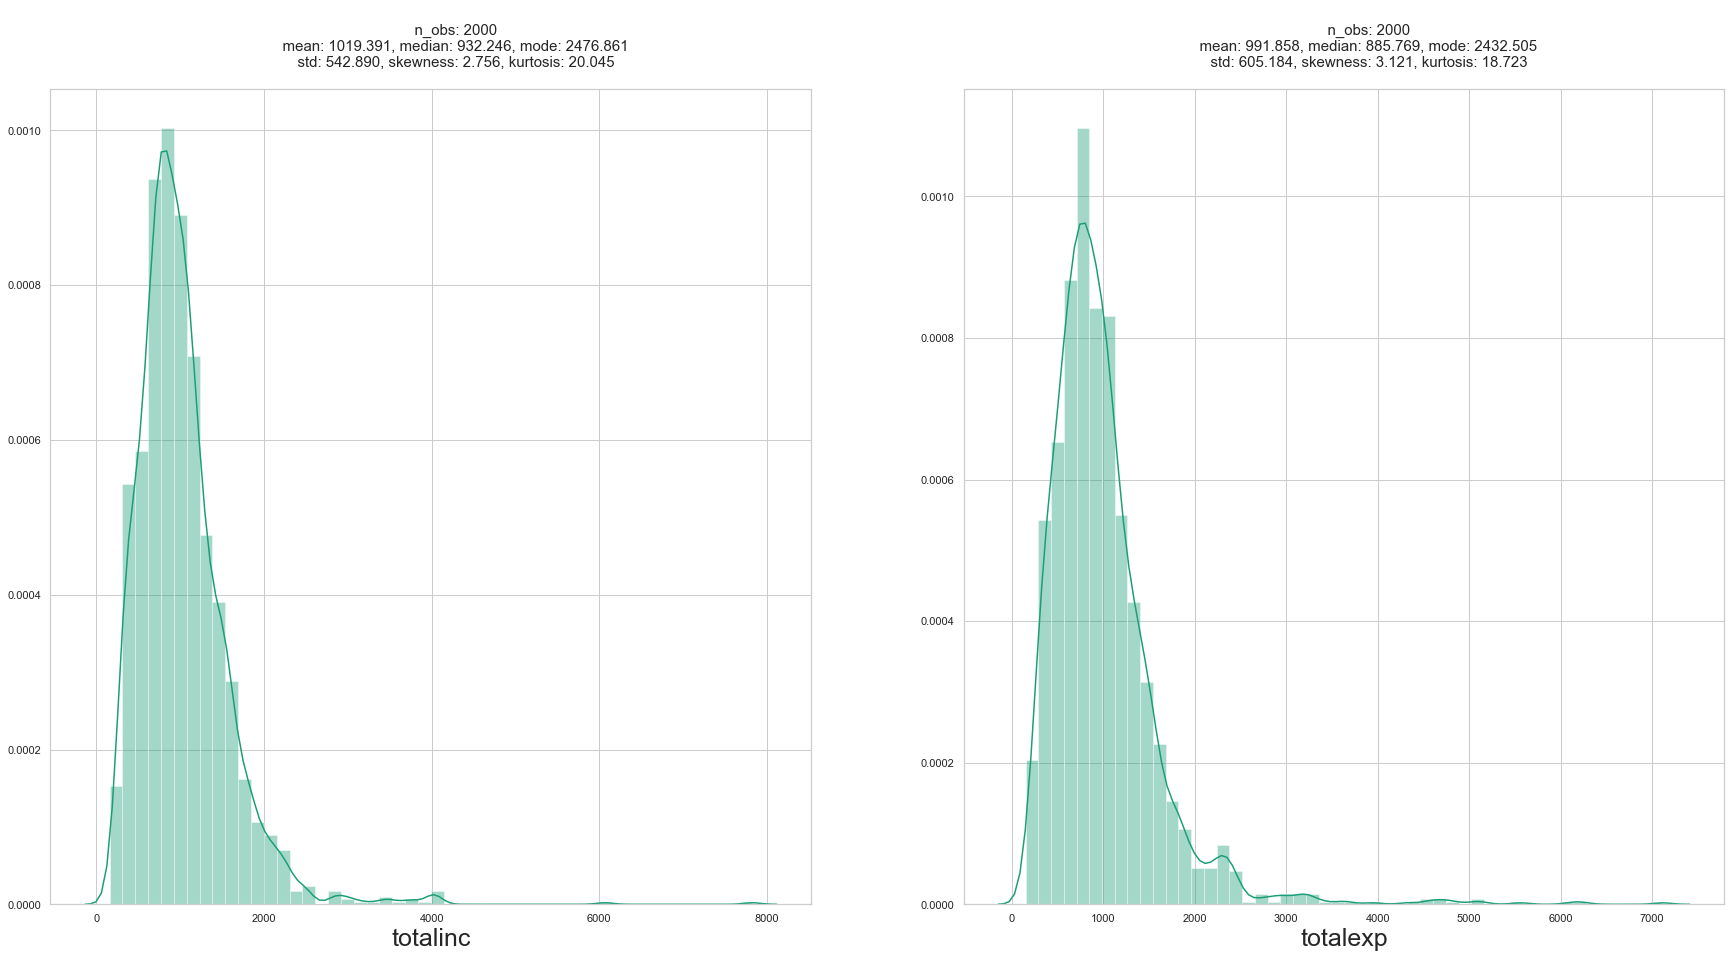

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

sns.distplot(df["totalinc"], ax=axes[0]).set_title(
    get_stats(df["totalinc"]), fontsize=15)
axes[0].set_xlabel("totalinc", fontsize=25)

sns.distplot(df["totalexp"], ax=axes[1]).set_title(
    get_stats(df["totalexp"]), fontsize=15)
axes[1].set_xlabel("totalexp", fontsize=25)

Рассматривая данные `inc_7` (стипендии) и `exp_7` (расходы на предметы бытового назначения) можно увидеть, что:

В `inc_7` видно, что этот признак для большинства наблюдений равен 0, оставшиеся распределяются от 1 до 249,7. Доля этой графы во всех доходах в среднем равна 2%.

В `exp_7` для большинства наблюдений лежит в интервале 0-120, а для оставшихся значений до 390.

Text(0.5, 0, 'exp_7 часть в totalexp [где exp_7 != 0]')

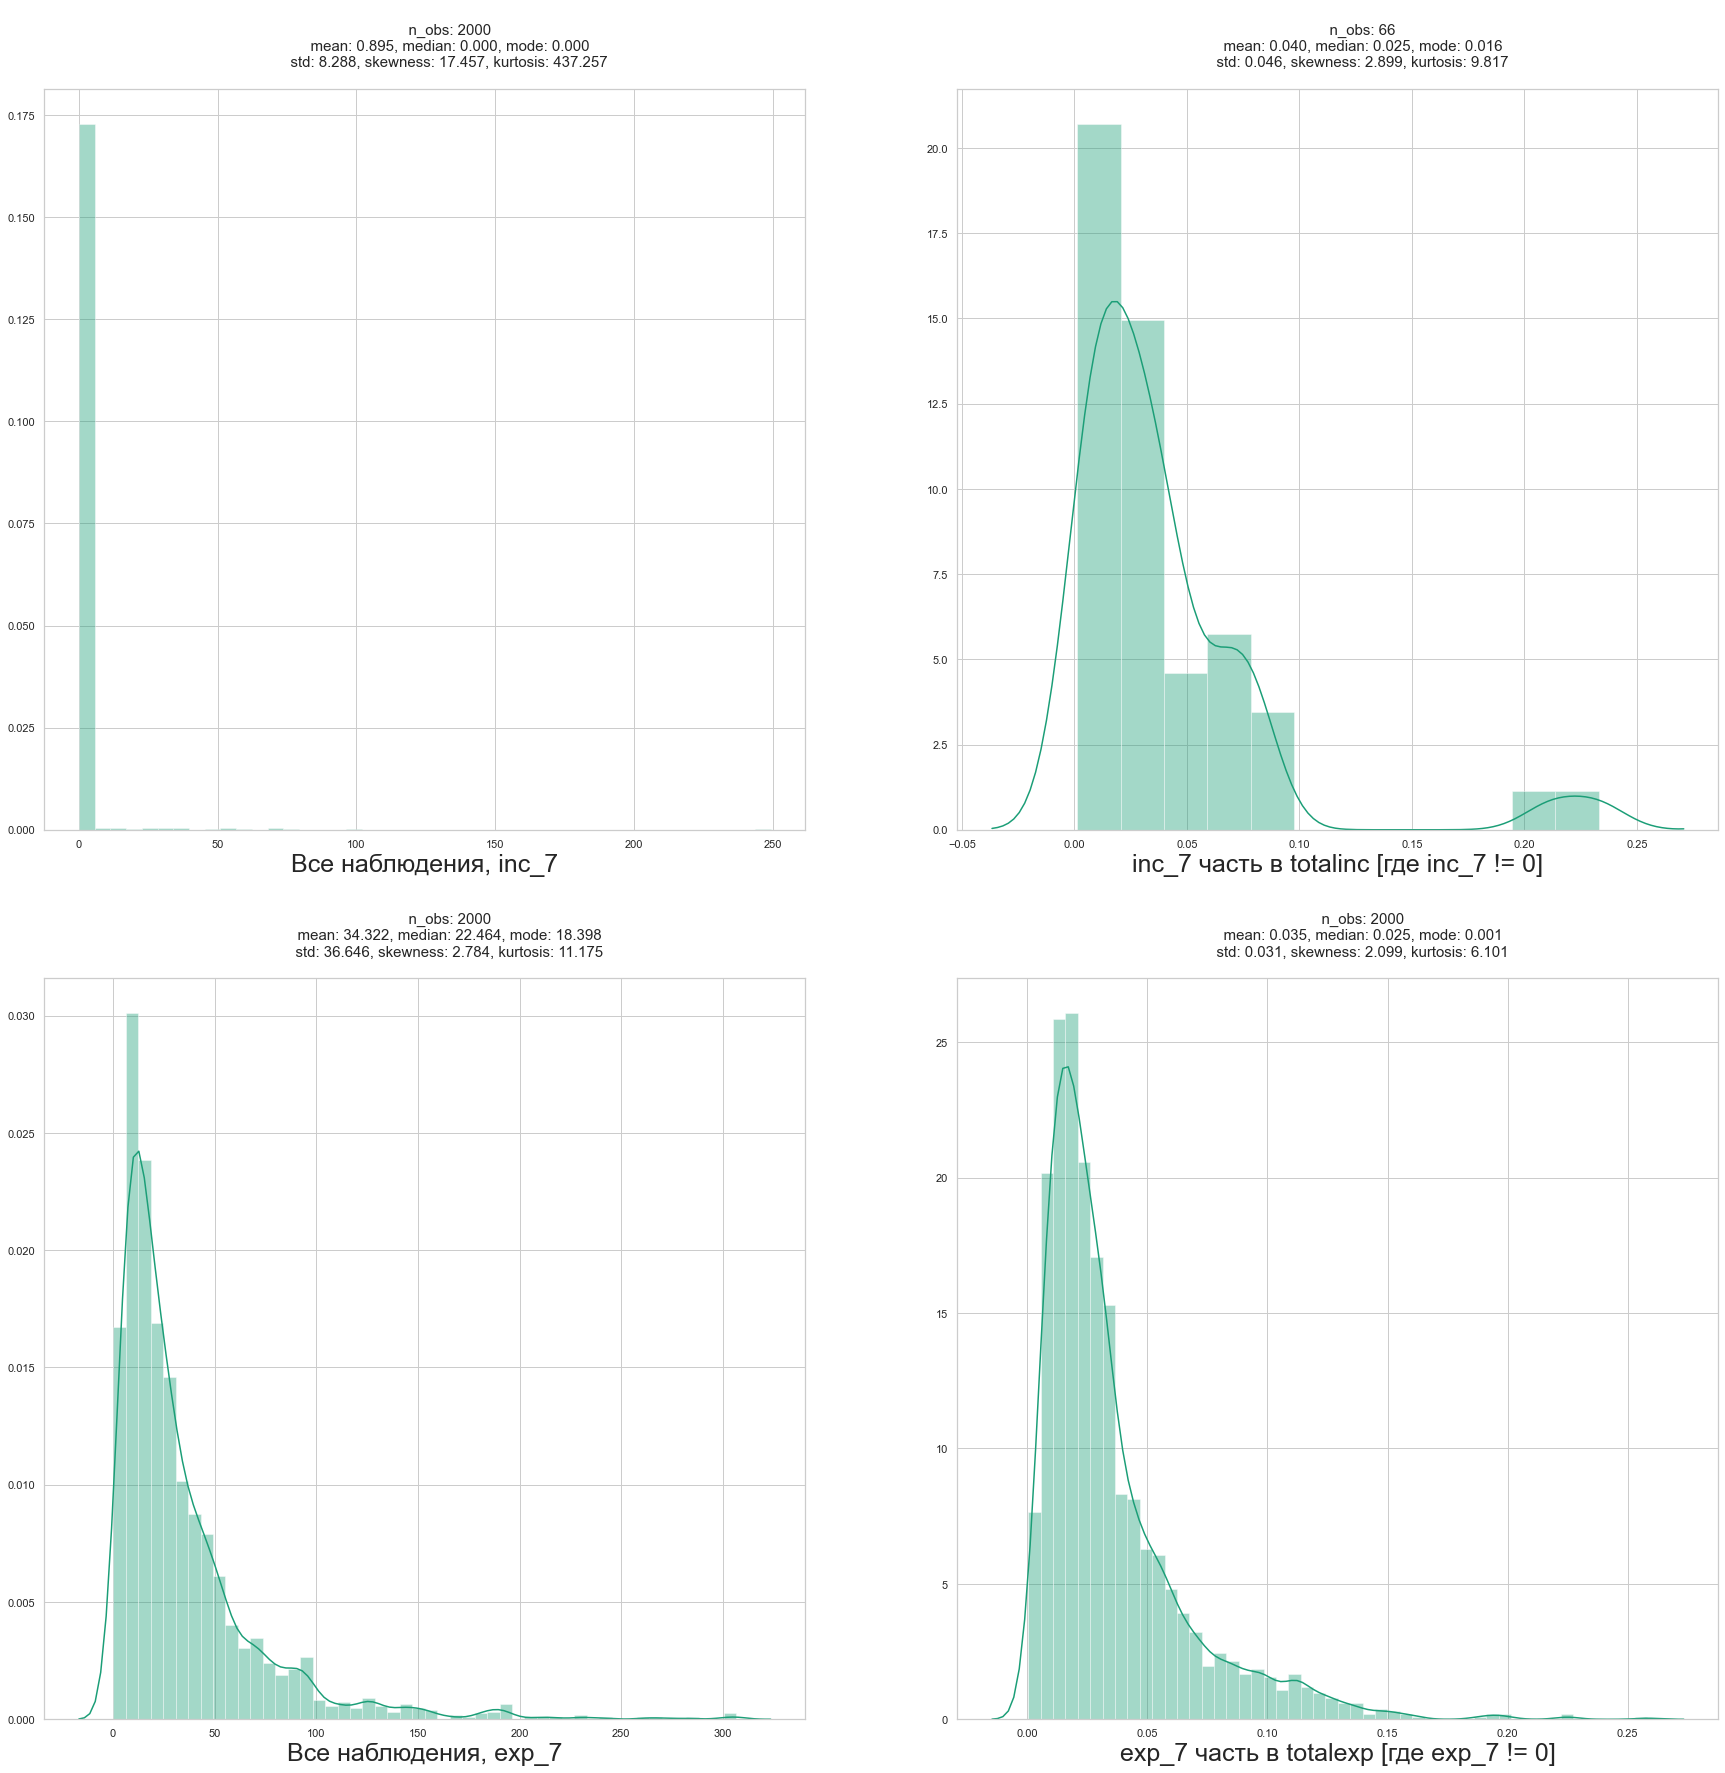

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

sns.distplot(df["inc_7"], ax=axes[0][0]).set_title(
    get_stats(df["inc_7"]), fontsize=15)
axes[0][0].set_xlabel("Все наблюдения, inc_7", fontsize=25)
    
nonzero_inc7_fraction = df[df["inc_7"] != 0]["inc_7"]/df[df["inc_7"] != 0]["totalinc"]
sns.distplot(nonzero_inc7_fraction, ax=axes[0][1]).set_title(
    get_stats(nonzero_inc7_fraction), fontsize=15)
axes[0][1].set_xlabel(f"inc_7 часть в totalinc [где inc_7 != 0]", fontsize=25)

sns.distplot(df["exp_7"], ax=axes[1][0]).set_title(
    get_stats(df["exp_7"]), fontsize=15)
axes[1][0].set_xlabel("Все наблюдения, exp_7", fontsize=25)

nonzero_exp7_fraction = df[df["exp_7"] != 0]["exp_7"]/df[df["exp_7"] != 0]["totalexp"]
sns.distplot(nonzero_exp7_fraction, ax=axes[1][1]).set_title(
    get_stats(nonzero_exp7_fraction), fontsize=15)
axes[1][1].set_xlabel(f"exp_7 часть в totalexp [где exp_7 != 0]", fontsize=25)

- Возраст (`age`) имеет распределение, похожее на равномерное (от 30 до 70 лет), чуть меньше наблюдений до и после 70 лет
- Вес (`weight`) имеет нормальное распределение с центром в 77 кг (редко встречаются "выбросы" больше 120 кг)
- Рост(`height`) имеет нормальное распределение с центром в 168 см (без выбросов как для веса, что логично)
- Индекс массы тела (`BMI`) также почти имеет нормальное распределение с центром в 26 (но из-за "выбросов" с ИМТ > 40 появляется небольшое смещение)

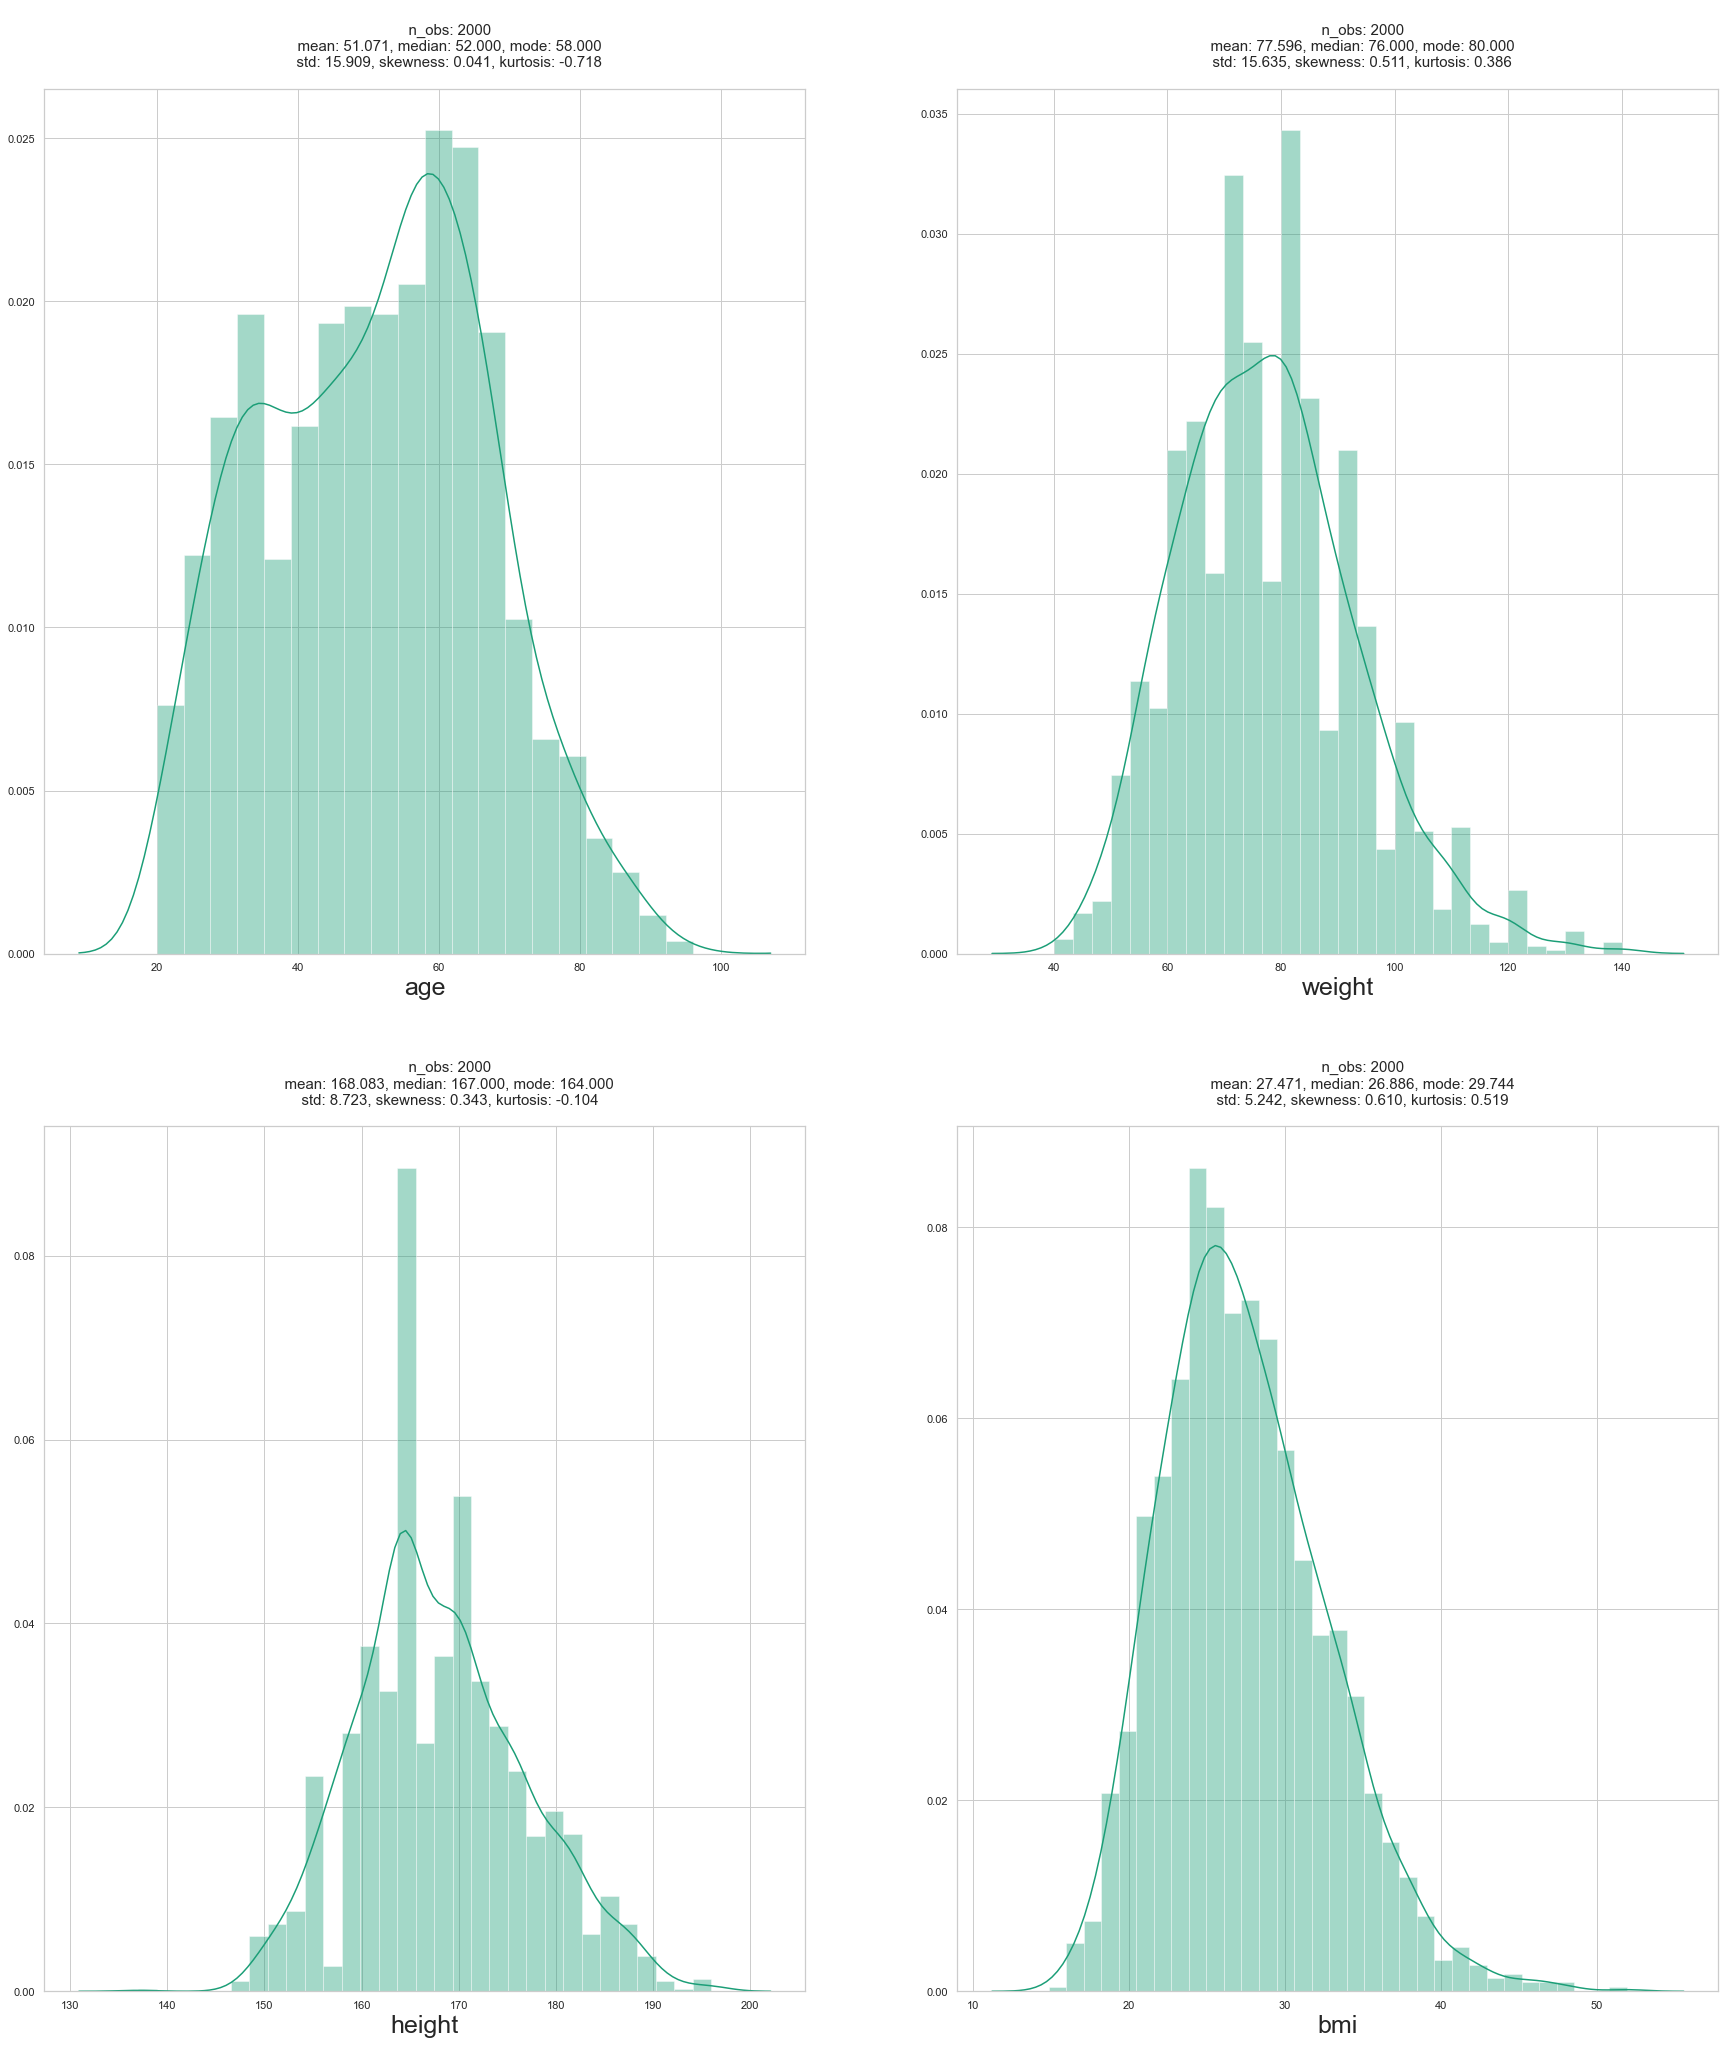

In [70]:
cols_to_plot = ["age", "weight", "height", "bmi"]
fig, axes = plt.subplots(2, 2, figsize=(30, 35))
axes = axes.reshape(-1)

for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.distplot(df[col], ax=axes[i]).set_title(get_stats(df[col]), fontsize=15)
    axes[i].set_xlabel(col, fontsize=25)

- Женщин в датасете больше, чем мужчин: 1200 v 800
- Регионы представлены примерно одинаково. Меньше всего - в Гродненской области (12.15%), больше всего - в Гомельской (16.30%). В Минске живет 2 млн человек (больше 20% населения страны), а в датасете его 13.75%. Хотя на взвешенной выборке ситуация меняется и Минск в ней представлен больше всего
- По типам домохозяйств доминируют "2 и более взрослых с детьми" и "домохозяйство без детей", меньше всего семей с одним родителем
- Самые распространённые домохозяйства - из двух (для невзвешенной выборки) и двух-трёх человек (для взвешенной выборки)
- Самый популярный уровень образования - средне-специальное, меньше всего по уровню образования людей без него вовсе
- Большинство оценивает своё здоровье как нормальное (не очень хорошее, не очень плохое). Людей, считающий, что у них хорошее здоровье в 2 раза больше, чем считающих, что плохое

Невзвешенная выборка:


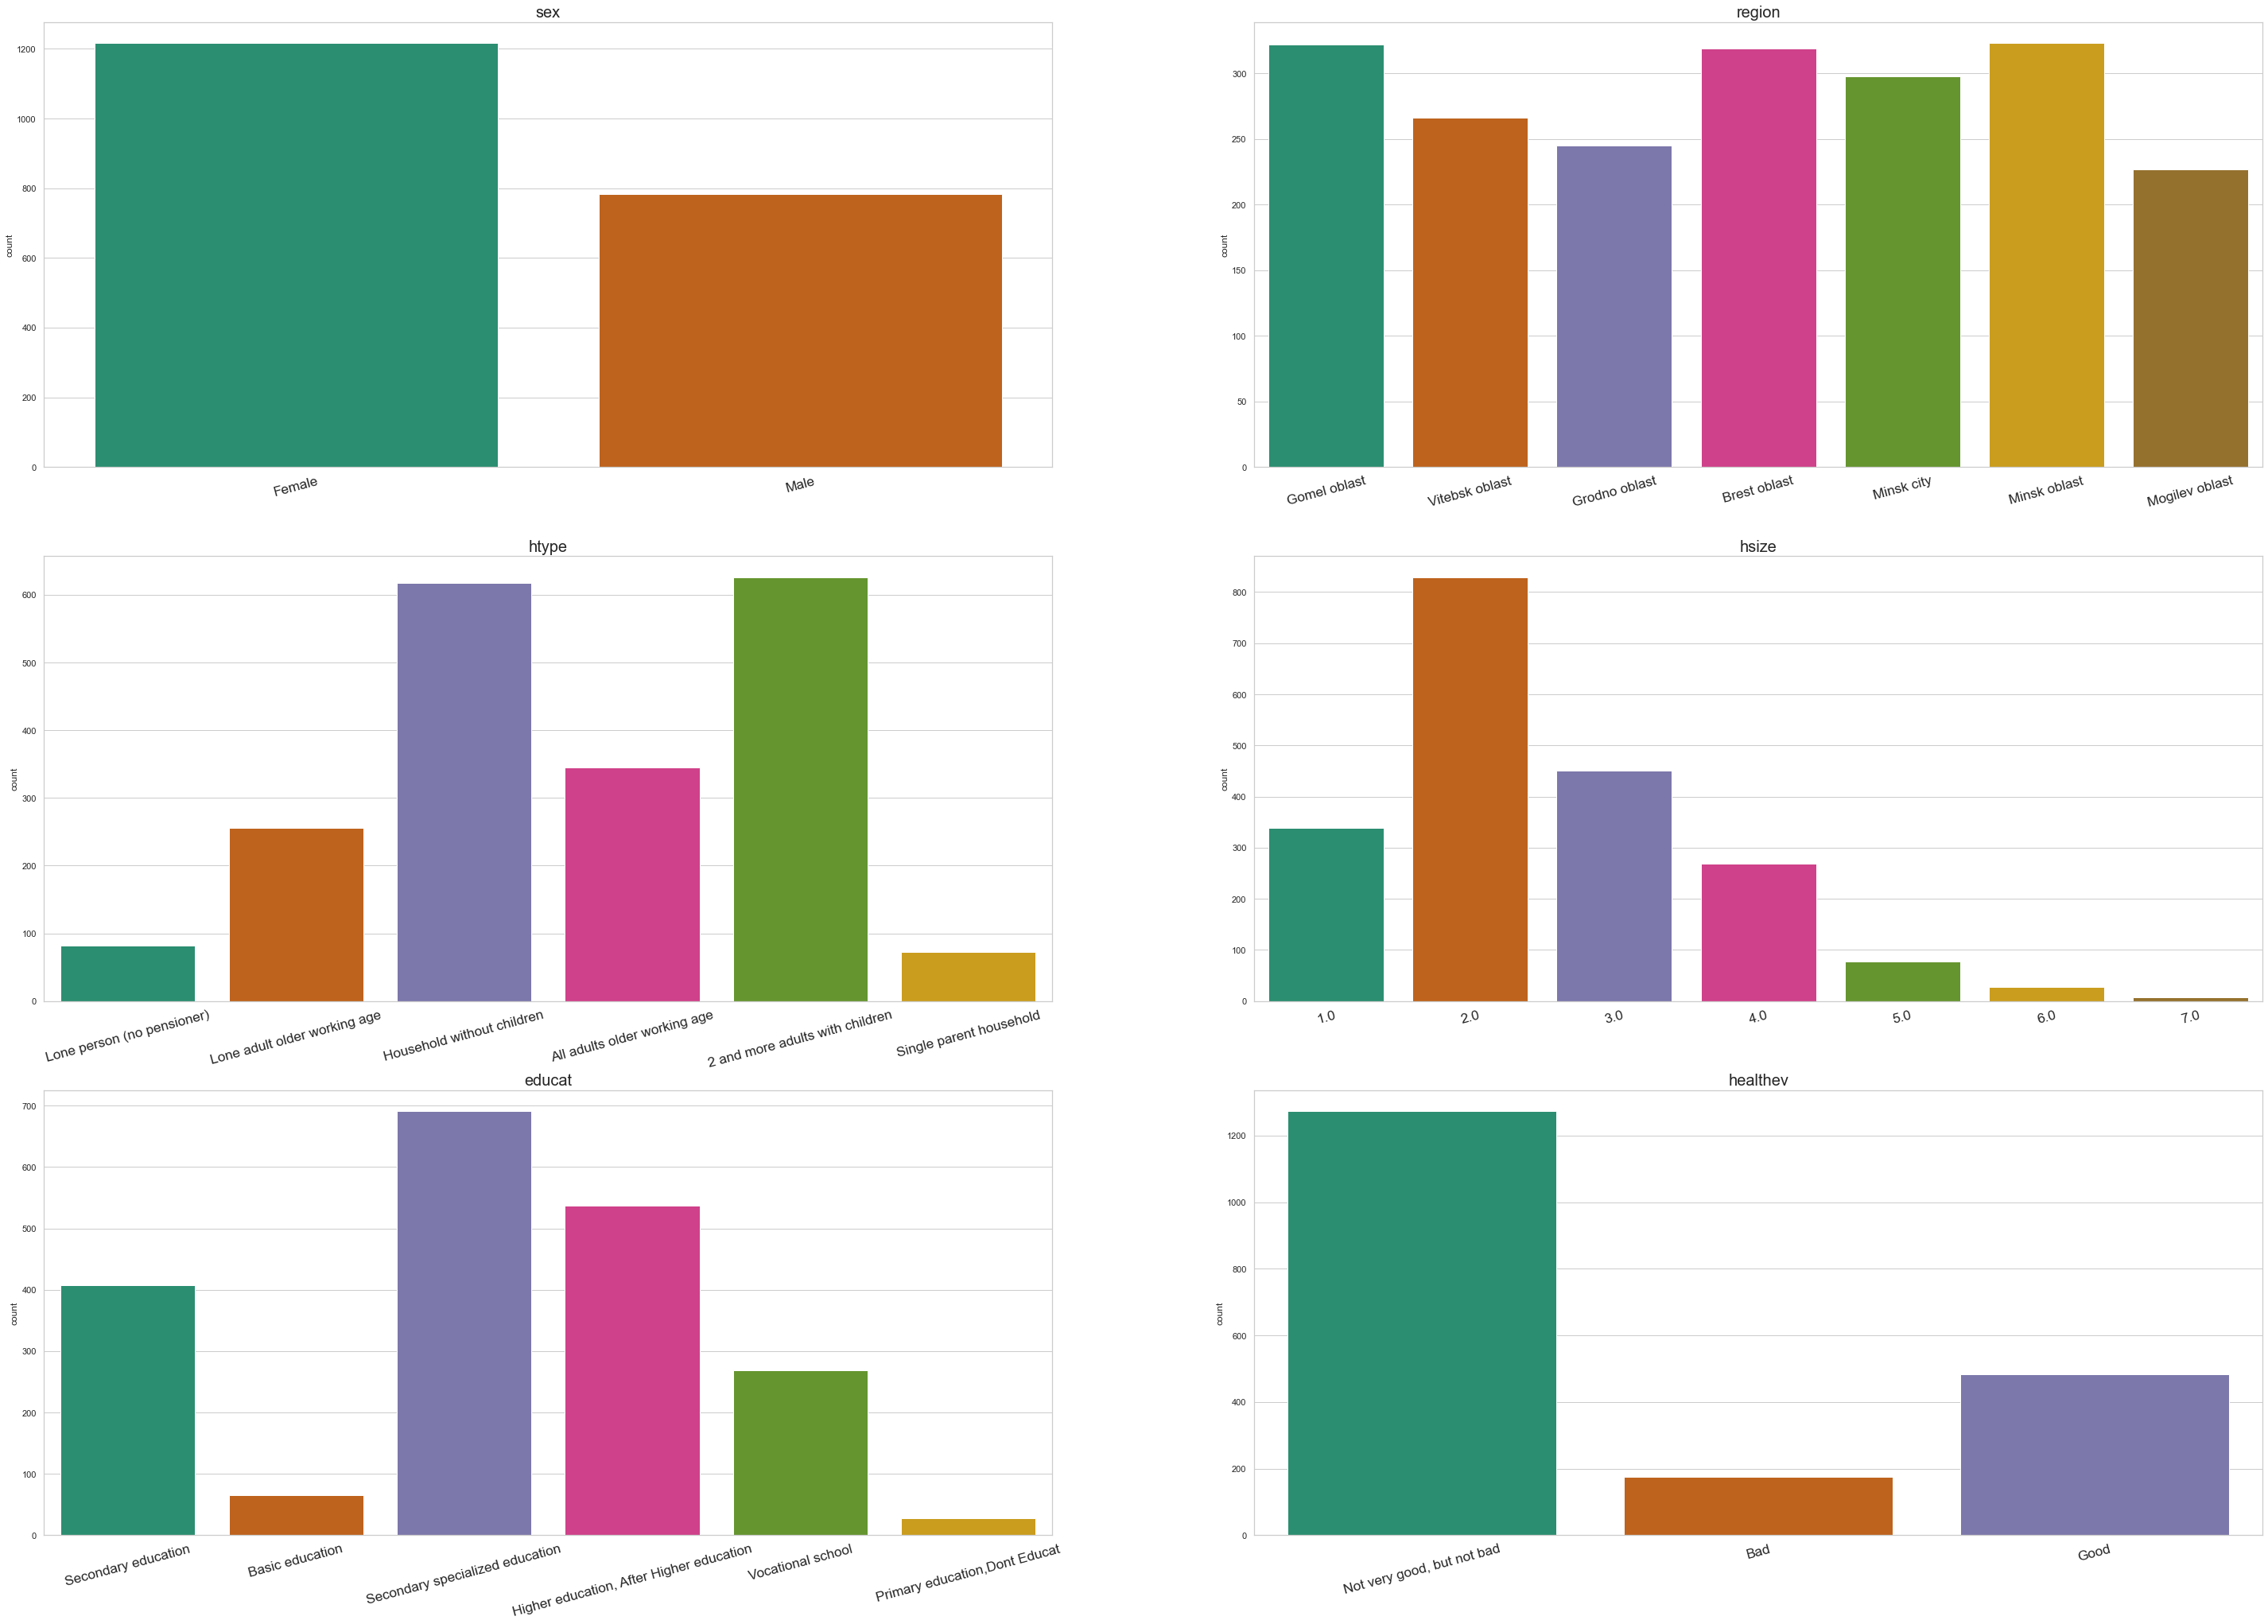

In [73]:
cols_to_plot = ["sex", "region", "htype", "hsize", "educat", "healthev"]
fig, axes = plt.subplots(3, 2, figsize=(50, 35))
axes = axes.reshape(-1)
for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.countplot(df[~df[col].isna()][col], ax=axes[i]).set_title(col, fontsize=20)
    plt.setp(axes[i].get_xticklabels(), rotation=15, fontsize='x-large')
    axes[i].set_xlabel(None)
    
print("Невзвешенная выборка:")

Взвешенная выборка:


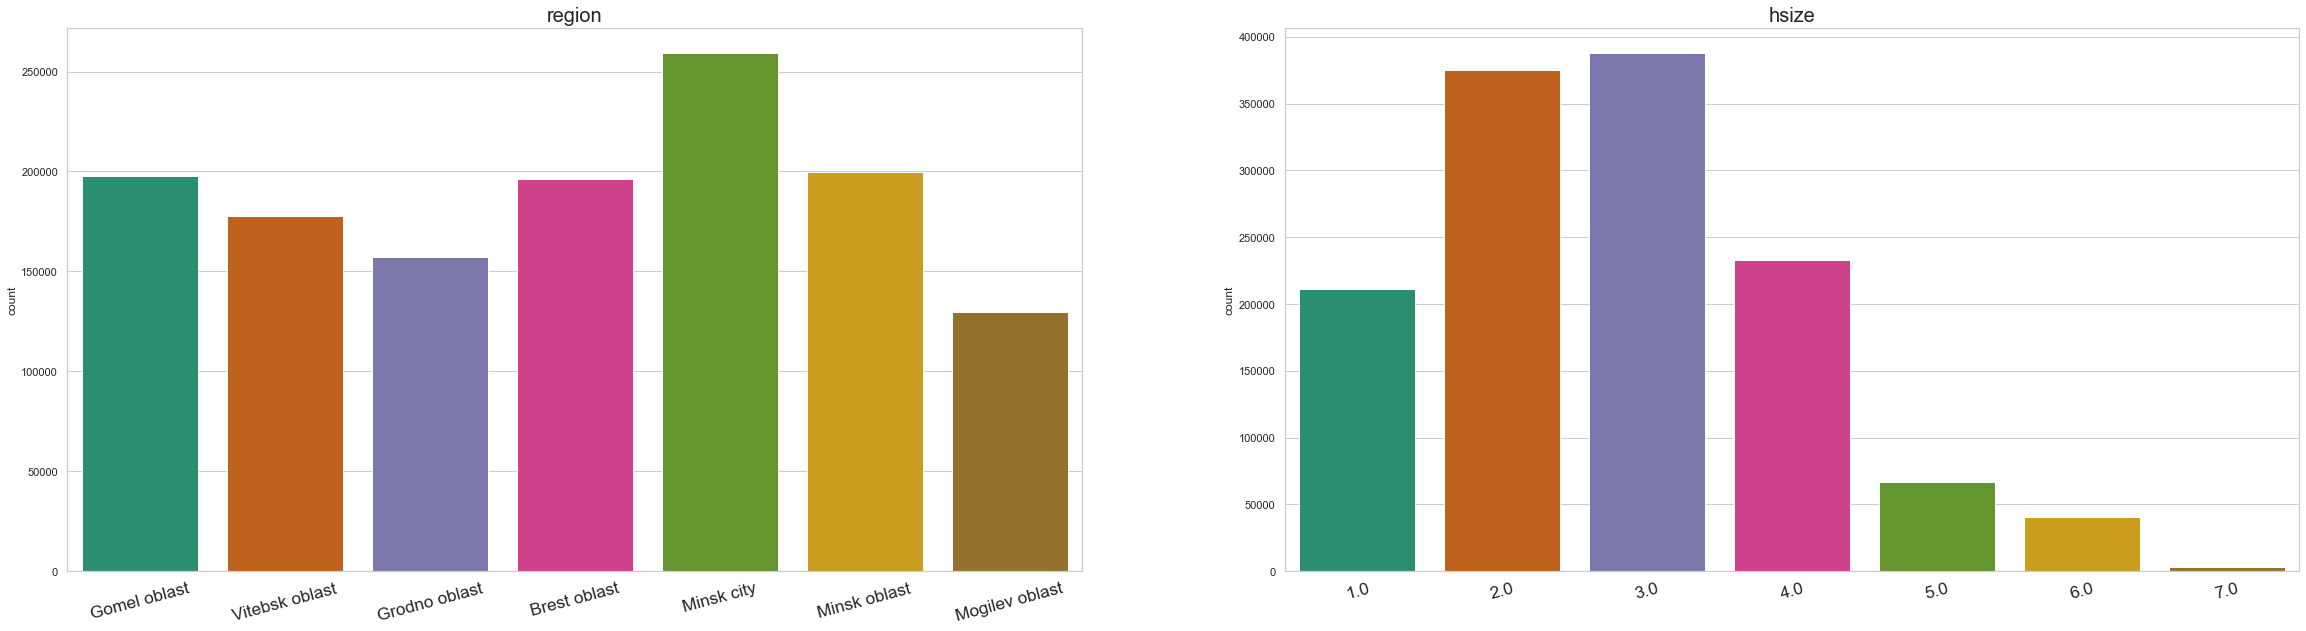

In [75]:
cols_to_plot = ["region", "hsize"]

fig, axes = plt.subplots(1, 2, figsize=(40, 10))
axes = axes.reshape(-1)
for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.countplot(weighted_df[~weighted_df[col].isna()][col], ax=axes[i]).set_title(col, fontsize=20)
    plt.setp(axes[i].get_xticklabels(), rotation=15, fontsize='x-large')
    axes[i].set_xlabel(None)
    
print("Взвешенная выборка:")

Распределения зарплат (`ppinc_1`) и сбережений (`savings`) не сильно меняются для взвешенной и невзвешенной выборки, что говорит о репрезентативности выборки по этим параметрам. Почти все зарплаты находятся в промежутке от 0 до 1500 рублей. В среднем люди "живут в ноль": не откладывают и не уходят в минусы, у большинства не получается откладывать больше 500 рублей. Треть страны живёт "в минус"

Text(0.5, 0, 'Взвешенная savings')

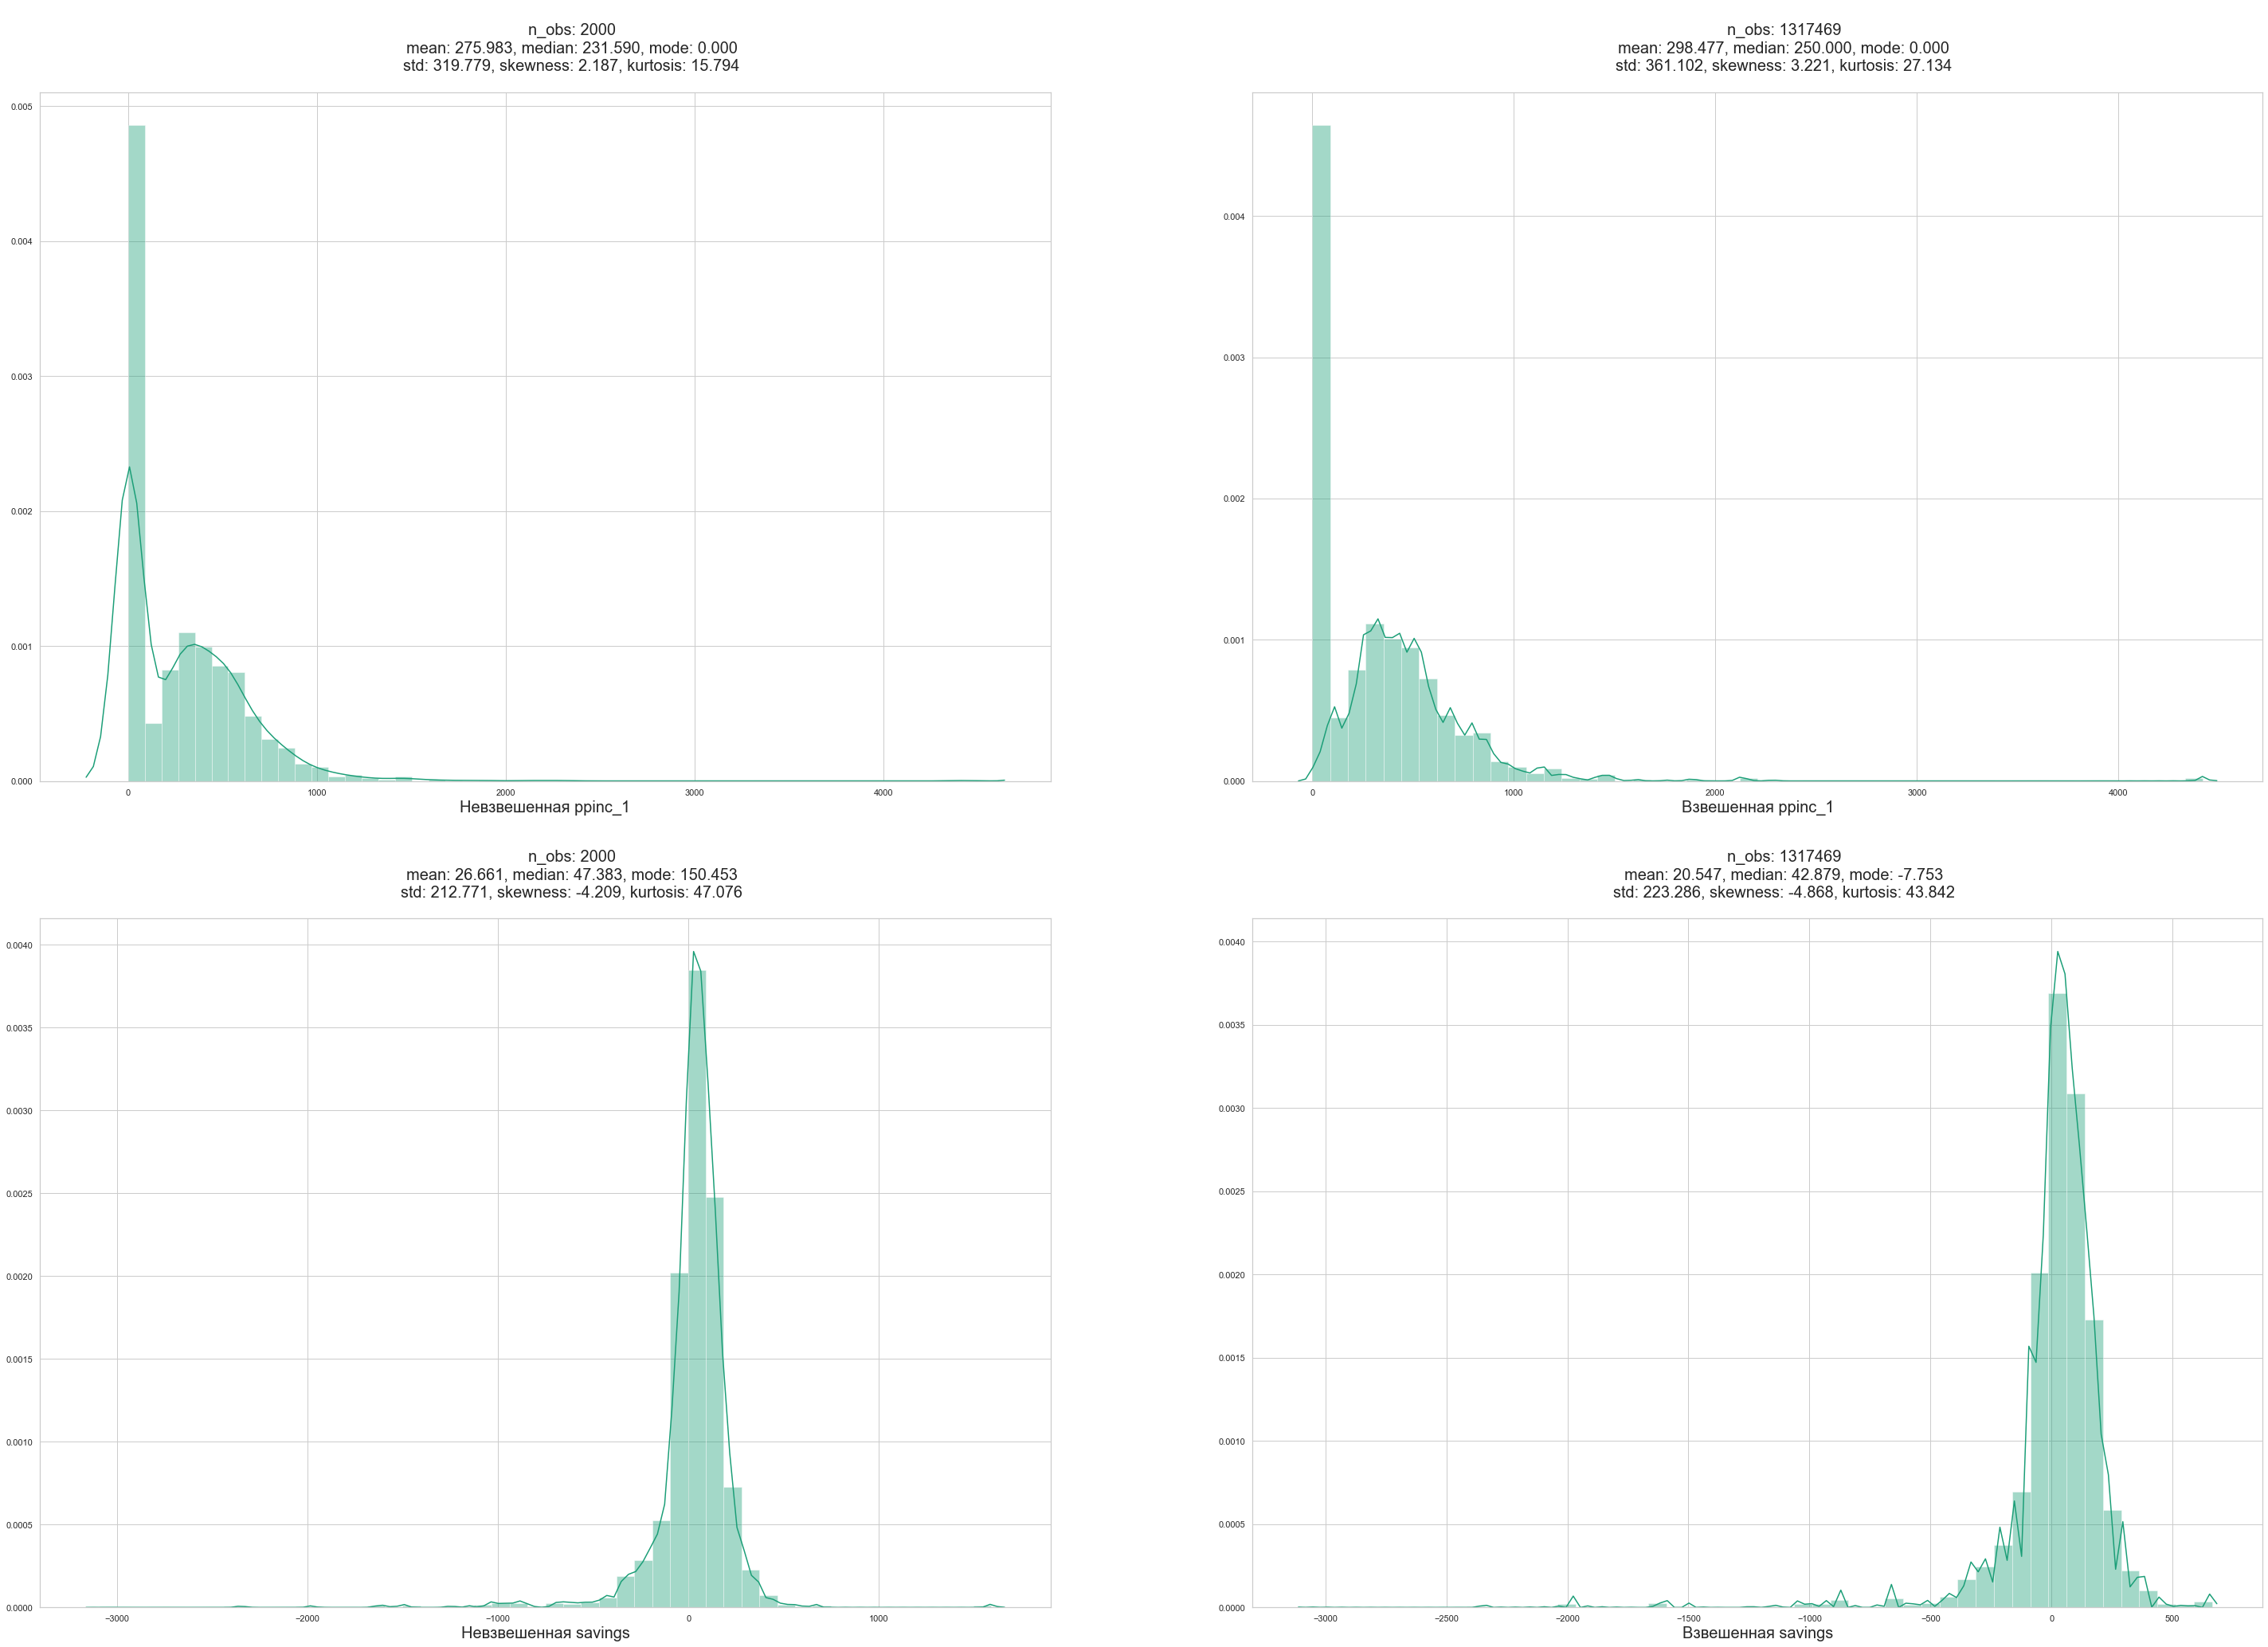

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(50, 35))
axes = axes.reshape(-1)

sns.distplot(df["ppinc_1"], ax=axes[0]).set_title(get_stats(df["ppinc_1"]), fontsize=20)
axes[0].set_xlabel("Невзвешенная ppinc_1", fontsize=20)

sns.distplot(weighted_df["ppinc_1"], ax=axes[1]).set_title(get_stats(weighted_df["ppinc_1"]), fontsize=20)
axes[1].set_xlabel("Взвешенная ppinc_1", fontsize=20)


sns.distplot(df["savings"], ax=axes[2]).set_title(get_stats(df["savings"]), fontsize=20)
axes[2].set_xlabel("Невзвешенная savings", fontsize=20)

sns.distplot(weighted_df["savings"], ax=axes[3]).set_title(get_stats(weighted_df["savings"]), fontsize=20)
axes[3].set_xlabel("Взвешенная savings", fontsize=20)

## 3) Провести анализ преобразованных значений количественных переменных из 2а

Логарифмическое преобразование делает распределение признаков `totalinc`, `totalexp` и `inc_7/totalinc` (для ненулевых `inc_7`) намного ближе к нормальному 

Признаки `exp_7/totalexp` (для ненулевых `exp_7`) не являются лог-нормальными, поэтому данное преобразование не помогло 

Признаки `weight`, `height` и `bmi` и так были нормально распределенными, так что это преобразование им не нужно

Стандартизация (приведение к нулевому среднему и единичной дисперсии) не изменила форму распределения данных, а только их масштаб.

Text(0.5, 0, 'standardize(exp_7 part)')

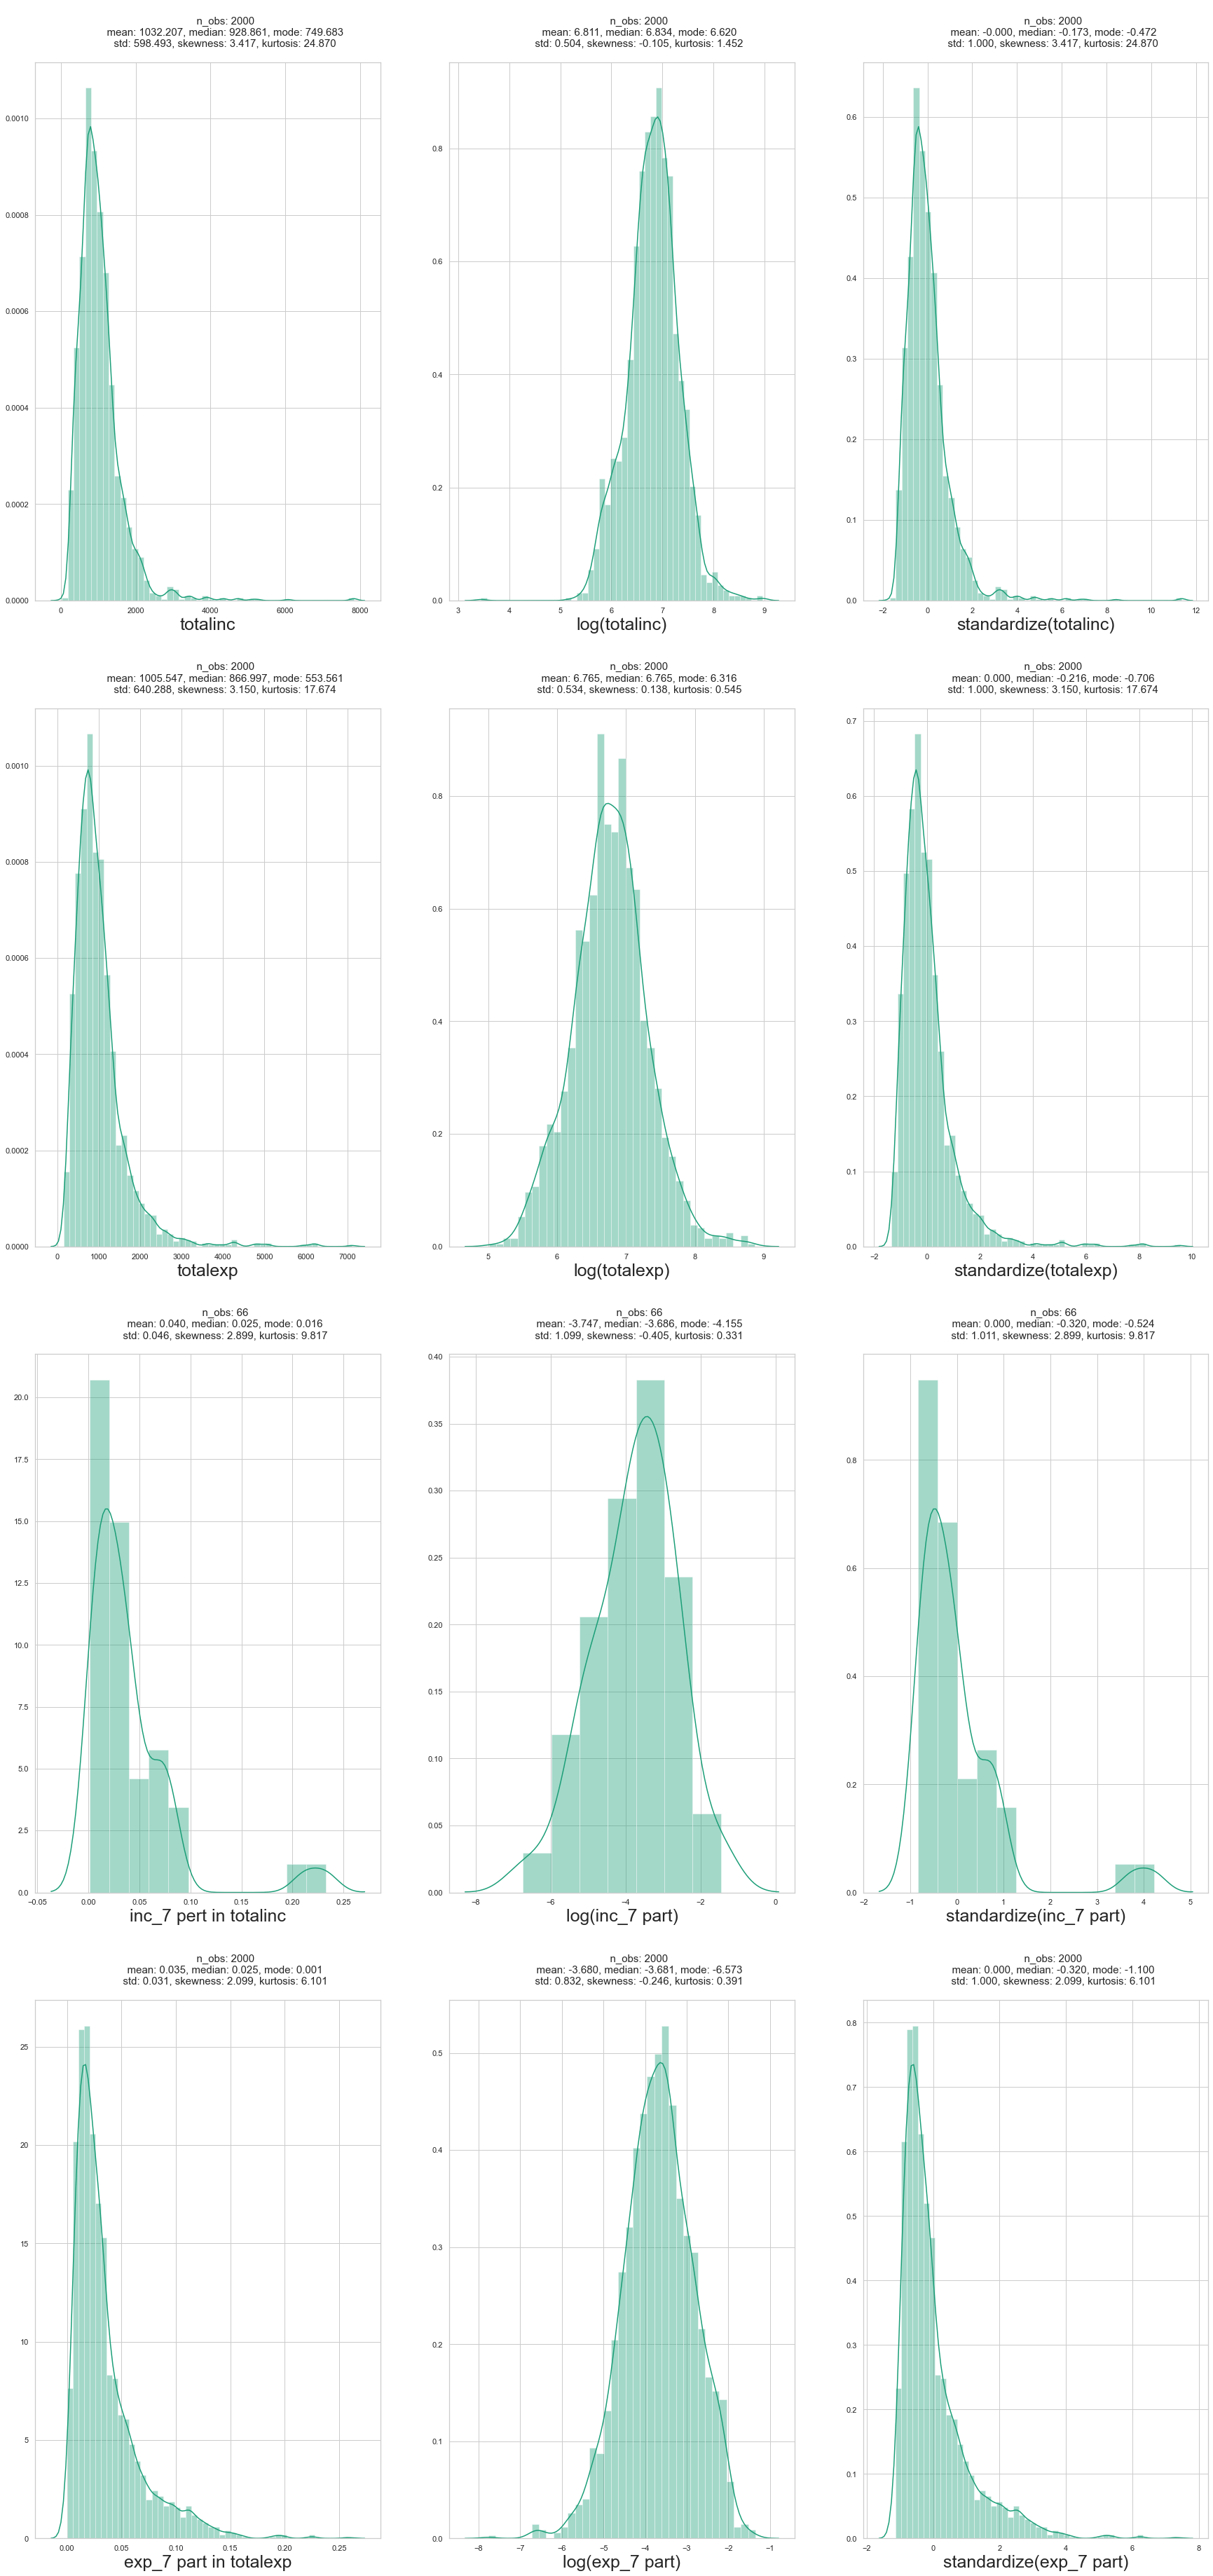

In [96]:
fig, axes = plt.subplots(4, 3, figsize=(30, 65))

sns.distplot(df["totalinc"], ax=axes[0][0]).set_title(
    get_stats(df["totalinc"]), fontsize=15
)
axes[0][0].set_xlabel("totalinc", fontsize=25)
    
log_totalinc = np.log(df["totalinc"])
sns.distplot(log_totalinc, ax=axes[0][1]).set_title(
    get_stats(log_totalinc), fontsize=15
)
axes[0][1].set_xlabel(f"log(totalinc)", fontsize=25)

standard_totalinc = standardize(df["totalinc"])
sns.distplot(standard_totalinc, ax=axes[0][2]).set_title(
    get_stats(standard_totalinc), fontsize=15
)
axes[0][2].set_xlabel(f"standardize(totalinc)", fontsize=25)

sns.distplot(df["totalexp"], ax=axes[1][0]).set_title(
    get_stats(df["totalexp"]), fontsize=15
)
axes[1][0].set_xlabel("totalexp", fontsize=25)
    
log_totalexp = np.log(df["totalexp"])
sns.distplot(log_totalexp, ax=axes[1][1]).set_title(
    get_stats(log_totalexp), fontsize=15
)
axes[1][1].set_xlabel(f"log(totalexp)", fontsize=25)

standard_totalexp = standardize(df["totalexp"])
sns.distplot(standard_totalexp, ax=axes[1][2]).set_title(
    get_stats(standard_totalexp), fontsize=15
)
axes[1][2].set_xlabel(f"standardize(totalexp)", fontsize=25)

sns.distplot(nonzero_inc7_fraction, ax=axes[2][0]).set_title(
    get_stats(nonzero_inc7_fraction), fontsize=15
)
axes[2][0].set_xlabel(f"inc_7 pert in totalinc", fontsize=25)

sns.distplot(np.log(nonzero_inc7_fraction), ax=axes[2][1]).set_title(
    get_stats(np.log(nonzero_inc7_fraction)), fontsize=15
)
axes[2][1].set_xlabel(f"log(inc_7 part)", fontsize=25)

sns.distplot(standardize(nonzero_inc7_fraction), ax=axes[2][2]).set_title(
    get_stats(standardize(nonzero_inc7_fraction)), fontsize=15
)
axes[2][2].set_xlabel(f"standardize(inc_7 part)", fontsize=25)

sns.distplot(nonzero_exp7_fraction, ax=axes[3][0]).set_title(
    get_stats(nonzero_exp7_fraction), fontsize=15
)
axes[3][0].set_xlabel(f"exp_7 part in totalexp", fontsize=25)

sns.distplot(np.log(nonzero_exp7_fraction), ax=axes[3][1]).set_title(
    get_stats(np.log(nonzero_exp7_fraction)), fontsize=15
)
axes[3][1].set_xlabel(f"log(exp_7 part)", fontsize=25)

sns.distplot(standardize(nonzero_exp7_fraction), ax=axes[3][2]).set_title(
    get_stats(standardize(nonzero_exp7_fraction)), fontsize=15
)
axes[3][2].set_xlabel(f"standardize(exp_7 part)", fontsize=25)

# №2. Задания по исследование однородности данных домохозяйств методами проверки гипотез, дисперсионного анализа и таблиц сопряженности.

In [98]:
df = pd.read_csv(DATA_PATH + 'df.csv', index_col="Unnamed: 0")
weighted_df = pd.read_csv(DATA_PATH + 'weighted_df.csv', index_col="Unnamed: 0")

print("df shape:", df.shape)
print("weighted df shape:", weighted_df.shape)

df shape: (2000, 74)
weighted df shape: (1317469, 74)


## 1) Проверить, равна ли средняя зарплата по выборке (использовать как невзвешенное, так и взвешенное среднее при расчете) статистически равна средней номинальной начисленной зарплате за 2017 г. (815.25), можно (при необходимости, использовать одновыборочный t-тест);
По итогу для двух выборок (невзвешенной и взвешенной) нулевая гипотеза о равенстве средней зарплаты 815.25 рублей не принимается, т.к. уровень значимости теста `p-value` = 0. 

Также видно, что по результатам теста среднее значение зарплаты по невзвешенной выборке равно 463 рубля, по взвешенной выборке - 488 рублей.


In [99]:
df_nonzero_salary = df[df["ppinc_1"] != 0]
weighted_df_nonzero_salary = weighted_df[weighted_df["ppinc_1"] != 0]

print("Non-weighted df, t-test на равенство среднего 815.25 рублям:", stats.ttest_1samp(
    df_nonzero_salary["ppinc_1"],
    815.25)
)
print("ppinc_1 mean (non-weighted):", df_nonzero_salary["ppinc_1"].mean())


print("\nWeighted df, t-test на равенство среднего 815.25 рублям:",stats.ttest_1samp(
    weighted_df_nonzero_salary["ppinc_1"],
    815.25)
)
print("ppinc_1 mean (weighted):", weighted_df_nonzero_salary["ppinc_1"].mean())

Non-weighted df, t-test на равенство среднего 815.25 рублям: Ttest_1sampResult(statistic=-41.68653626901219, pvalue=6.89111366860761e-235)
ppinc_1 mean (non-weighted): 463.4474293310945

Weighted df, t-test на равенство среднего 815.25 рублям: Ttest_1sampResult(statistic=-846.1000988966557, pvalue=0.0)
ppinc_1 mean (weighted): 487.7856088231451


## 2) Проверить гипотезу об равенстве средних значений (двухвыборочный t-test) и дисперсий (критерий Ливиня) количественных в двух группах:
1. зарплату для мужчин и женщин;
2. inc_7, exp_7 для домохозяйств из любых двух регионов.
Для этого необходимо провести двухвыборочный t-test и levene-тест для выборок мужчин и женщин с ненулевой зарплатой  
Для всех критериев `p-value = 0` 

Проверим результаты тестов:
- по невзвешенной выборке среднее значение зарплат у мужчин = 538 рублей
- по невзвешенной выборке среднее значение зарплат у женщин = 402 рубля

- по невзвешенной выборке стандартное отклонение зарплат мужчин = 353
- по невзвешенной выборке стандартное отклонение зарплат женщин = 211

- по взвешенной выборке среднее значение зарплаты мужчин = 584 рубля
- по взвешенной выборке среднее значение зарплаты мужчин = 408 рублей

- по взвешенной выборке стандартное отклонение зарплат мужчин = 438
- по взвешенной выборке стандартное отклонение зарплат женщин = 217

По данной выборке нельзя сказать о равенстве зарплат мужчин и женщин, как, собственно, и о равенстве их дисперсий.
В среднем зарплаты мужчин в 1.38 раза выше, чем зарплаты женщин. Аналогичное можно сказать и про дисперсии.

In [100]:
print("t-test на равенство средних:", stats.ttest_ind(
    df_nonzero_salary[df_nonzero_salary["sex"] == "Male"]["ppinc_1"],
    df_nonzero_salary[df_nonzero_salary["sex"] == "Female"]["ppinc_1"]))

print("levene критерий на равенство дисперсий:", stats.levene(
    df_nonzero_salary[df_nonzero_salary["sex"] == "Male"]["ppinc_1"],
    df_nonzero_salary[df_nonzero_salary["sex"] == "Female"]["ppinc_1"]))

print("\n\tMale ppinc_1 mean (non-weighted):", df_nonzero_salary[df_nonzero_salary["sex"] == "Male"]["ppinc_1"].mean())
print("\tFemale ppinc_1 mean (non-weighted):", df_nonzero_salary[df_nonzero_salary["sex"] == "Female"]["ppinc_1"].mean())
print("\n\tMale ppinc_1 std (non-weighted):", df_nonzero_salary[df_nonzero_salary["sex"] == "Male"]["ppinc_1"].std())
print("\tFemale ppinc_1 std (non-weighted):", df_nonzero_salary[df_nonzero_salary["sex"] == "Female"]["ppinc_1"].std())

print("\nWeighted df:")
print("t-test на равенство средних:", stats.ttest_ind(
    weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Male"]["ppinc_1"],
    weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Female"]["ppinc_1"]))

print("levene критерий на равенство дисперсий:", stats.levene(
    weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Male"]["ppinc_1"],
    weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Female"]["ppinc_1"])
)

print("\n\tMale ppinc_1 mean (weighted):", weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Male"]["ppinc_1"].mean())
print("\tFemale ppinc_1 mean (weighted):", weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Female"]["ppinc_1"].mean())
print("\n\tMale ppinc_1 std (weighted):", weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Male"]["ppinc_1"].std())
print("\tFemale ppinc_1 std (weighted):", weighted_df_nonzero_salary[weighted_df_nonzero_salary["sex"] == "Female"]["ppinc_1"].std())

t-test на равенство средних: Ttest_indResult(statistic=8.208073440768628, pvalue=5.795350339162212e-16)
levene критерий на равенство дисперсий: LeveneResult(statistic=29.6775401710007, pvalue=6.196644788160137e-08)

	Male ppinc_1 mean (non-weighted): 538.3519533041485
	Female ppinc_1 mean (non-weighted): 402.7724881796689

	Male ppinc_1 std (non-weighted): 352.85076177542027
	Female ppinc_1 std (non-weighted): 211.14886718692983

Weighted df:
t-test на равенство средних: Ttest_indResult(statistic=234.09018729781053, pvalue=0.0)
levene критерий на равенство дисперсий: LeveneResult(statistic=21326.69827908771, pvalue=0.0)

	Male ppinc_1 mean (weighted): 583.6203151085869
	Female ppinc_1 mean (weighted): 407.5867880530235

	Male ppinc_1 std (weighted): 438.15439994197845
	Female ppinc_1 std (weighted): 216.87517992697988


## Проверка гипотез о равенстве средних и дисперсии `inc_7` и `exp_7` у людей в Брестской и Витебской областях  
Подход аналогичный предыдущему пункту для зарплат у мужчин и женщин.  
Так как `p-value > 0.05` (`0.24, 0.24, 0.79 и 0.79)` для всех тестов, то мы не можем отвергнуть ни одну из нулевых гипотез. То есть средние значения и дисперсия `inc_7` для людей в Минской области и в Витебской области равны, тоже самое можно сказать и про `exp_7`.

Проверим результаты тестов:
- среднее значение `inc_7` в Брестской области = 0.7
- среднее значение `inc_7` в Витебской области = 0.5


- стандартное отклонение `inc_7` в Брестской области = 4.9
- стандартное отклонение `inc_7` в Витебской области = 4.4



- среднее значение `exp_7` в Брестской области = 36.5
- среднее значение `exp_7` в Витебской области = 33.4


- стандартное отклонение `exp_7` в Брестской области = 40.1
- стандартное отклонение `exp_7` в Витебской области = 33.5

Существенных различий не наблюдается, поэтому результаты тестов обоснованы

In [110]:
df_reg1 = df[df["region"] == "Brest oblast"][df['inc_7'].notna()]
df_reg2 = df[df["region"] == "Vitebsk oblast"][df['inc_7'].notna()]

print("inc_7:")
print("t-test на равенство средних:", stats.ttest_ind(
    df_reg1["inc_7"],
    df_reg2["inc_7"])
)

print("levene критерий на равенство дисперсий:", stats.levene(
    df_reg1["inc_7"],
    df_reg2["inc_7"])
)

print("\n\tBrest inc_7 mean:", df_reg1["inc_7"].mean())
print("\tVitebsk inc_7 mean:", df_reg2["inc_7"].mean())
print("\n\tBrest inc_7 std:", df_reg1["inc_7"].std())
print("\tVitebsk inc_7 std:", df_reg2["inc_7"].std())

print("\nexp_7:")
print("t-test на равенство средних:", stats.ttest_ind(
    df_reg1["exp_7"],
    df_reg2["exp_7"])
)

print("levene критерий на равенство дисперсий:", stats.levene(
    df_reg1["exp_7"],
    df_reg2["exp_7"])
)

print("\n\tBrest exp_7 mean:", df_reg1["exp_7"].mean())
print("\tVitebsk exp_7 mean:", df_reg2["exp_7"].mean())
print("\n\tBrest exp_7 std:", df_reg1["exp_7"].std())
print("\tVitebsk exp_7 std:", df_reg2["exp_7"].std())

inc_7:
t-test на равенство средних: Ttest_indResult(statistic=0.3115496025171167, pvalue=0.7554951799168353)
levene критерий на равенство дисперсий: LeveneResult(statistic=0.09706315482857342, pvalue=0.7554951799168237)

	Brest inc_7 mean: 0.6648206751054854
	Vitebsk inc_7 mean: 0.5432449494949495

	Brest inc_7 std: 4.928256998173999
	Vitebsk inc_7 std: 4.364245806339205

exp_7:
t-test на равенство средних: Ttest_indResult(statistic=0.9953896596069925, pvalue=0.3199633060741238)
levene критерий на равенство дисперсий: LeveneResult(statistic=0.46822024983170724, pvalue=0.49408133387399)

	Brest exp_7 mean: 36.49112341772156
	Vitebsk exp_7 mean: 33.39878787878786

	Brest exp_7 std: 40.130790695363125
	Vitebsk exp_7 std: 33.49561559701631


## 3) Создать на основе количественных переменных категориальные:
1. для возраста: выделить следующие категории: 18-24, 25-34, 35-44, 45-54, 55-64, остальным наблюдениям, не для которых возраст не входит в указанные категории, присвоить для данной переменной пропущенные значения;
2. для зарплаты (нижняя граница включается, верхняя нет): от 0 до 400, от 400 до 500, от 500 до 700, от 700 до 1000, от 1000; значение 0 считать при расчетах пропущенным;

In [111]:
df["age_categorical"] = df["age"].apply(lambda x : "18-24" if (x >= 18 and x <= 24)
                                                                        else "25-34" if (x >= 25 and x <= 34)
                                                                        else "35-44" if (x >= 35 and x <= 44)
                                                                        else "45-54" if (x >= 45 and x <= 54)
                                                                        else "55-64" if (x >= 55 and x <= 64)
                                                                        else pd.NA)
df["salary_categorical"] = df["ppinc_1"].apply(lambda x : pd.NA if (x == 0)
                                                                                    else "0-400" if (x > 0 and x < 400)
                                                                                    else "400-500" if (x >= 400 and x < 500)
                                                                                    else "500-700" if (x >= 500 and x < 700)
                                                                                    else "700-1000" if (x >= 700 and x < 1000)
                                                                                    else ">= 1000")
df

,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4,bmi,savings,age_categorical,salary_categorical
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.083333,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.083333,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.000000,243.083333,41.656204,0.000000,284.739537,19.165417,27.258333,10.653333,6.833333,0.0,43.461667,16.083333,17.220000,5.440833,81.583333,5.282500,3.875000,0.000000,0.0,20.287500,7.312500,0.0,0.0,0.000000,0.000000,7.806667,0.658333,32.641667,0.000000,0.000000,7.417500,21.975,7.500000,0.000000,309.152917,1.0,1.0,1.0,1.0,1.0,22.308150,-24.413379,45-54,0-400
2972,1653.0,1.0,2017.0,770,Rural,Vitebsk oblast,85.0,Female,0.000000,0.0,Basic education,Bad,75.0,170.0,No,No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,398.597500,0.0,0.000,0.0,8.333333,0.0,0.0,0.000000,406.930833,55.711985,0.000000,462.642819,156.246250,3.629167,25.250000,14.000000,0.0,41.724167,16.000000,9.882500,26.197500,0.000000,43.783333,0.400000,0.000000,0.0,6.089167,25.188333,0.0,0.0,0.000000,0.000000,3.770000,0.000000,7.500000,16.666667,0.000000,0.000000,0.000,52.500000,0.000000,422.944583,1.0,1.0,1.0,1.0,1.0,25.951557,39.698235,<NA>,<NA>
5787,3174.0,1.0,2017.0,415,Small city,Grodno oblast,57.0,Male,557.569167,12.0,Secondary education,"Not very good, but not bad",85.0,168.0,"Yes, in free time",Yes,Household without children,2.0,0.0,0.0,0.0,1.0,557.569167,0.0,0.0,233.666667,0.0,0.000,0.0,16.666667,0.0,0.0,0.000000,807.902500,141.351097,0.000000,949.253597,232.897917,40.745833,25.850000,18.000000,0.0,69.403333,6.666667,22.903333,50.652500,57.083333,17.800000,2.723333,2.879167,0.0,45.985000,11.645833,0.0,0.0,0.000000,0.000000,15.779167,10.808333,3.916667,66.666667,20.000000,0.000000,0.000,63.333333,0.000000,756.170417,1.0,1.0,1.0,1.0,1.0,30.116213,193.083180,55-64,500-700
5057,2756.0,2.0,2017.0,455,Rural,Gomel oblast,56.0,Female,0.000000,0.0,Secondary education,"Not very good, but not bad",71.0,161.0,No,No,Household without children,2.0,0.0,0.0,0.0,1.0,339.416667,0.0,0.0,401.586667,0.0,68.275,0.0,0.000000,0.0,0.0,41.883333,851.161667,213.953180,2.315000,1067.429847,288.599583,12.339167,29.700000,19.500000,0.0,45.670833,0.000000,36.570833,36.520833,0.000000,12.569167,9.370833,3.500000,0.0,22.210833,14.208333,0.0,0.0,62.500000,62.500000,10.751667,32.500000,48.304167,41.666667,0.000000,2.905000,0.000,153.333333,0.000000,846.150417,1.0,1.0,1.0,1.0,1.0,27.390919,221.279430,55-64,<NA>
2604,1449.0,2.0,2017.0,530,Small city,Vitebsk oblast,76.0,Male,0.000000,0.0,Secondary specialized education,"Not very good, but not bad",78.0,172.0,No,No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.000000,0.0,0.0,655.921667,0.0,0.000,0.0,50.000000,0.0,0.0,41.666667,747.588333,32.271567,0.455833,780.315733,168.314583,4.225000,10.273333,6.500000,0.0,51.561667,0.000000,37.310000,12.551667,0.000000,55.650000,1.666667,3.333333,0.0,6.119167,14.257500,0.0,0.0,66.666667,66.666667,10.336667,15.907500,7.083333,50.000000,69.250000,0.000000,0.000,208.000000,41.666667,803.363750,1.0,1.0,1.0,1.0,1.0,26.365603,-23.048017,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,741.0,1.0,2017.0,942,Rural,Brest oblast,40.0,Female,277.133333,12.

## 4) Построить таблицы сопряженности для следующих пар переменных (их категориальных версий): 
- пол и интервалы зарплат, возраст и интервалы зарплат, уровень образования и интервалы зарплат, уровень образования и частота занятий спортом (только на выборке понятных значений); 
- двухмерную таблицу для пола (sex) и бинарной переменной, характеризующей наличие привычки курения (smoker);

Таблица сопряженности для пола и зарплаты:

In [112]:
sex_salary_crosstab = pd.crosstab(df["sex"], df["salary_categorical"])
sex_salary_crosstab

salary_categorical,0-400,400-500,500-700,700-1000,>= 1000
sex,,,,,
Female,357,107,135,53,6
Male,189,80,147,80,37


Таблица сопряженности для возраста и зарплаты:

In [114]:
age_salary_crosstab = pd.crosstab(df["age_categorical"], df["salary_categorical"])
age_salary_crosstab

salary_categorical,0-400,400-500,500-700,700-1000,>= 1000
age_categorical,,,,,
18-24,22,3,9,5,1
25-34,97,42,47,33,12
35-44,107,49,83,40,13
45-54,145,63,82,35,10
55-64,146,27,58,19,7


Таблица сопряженности для уровня образования и зарплаты:

In [113]:
education_salary_crosstab = pd.crosstab(df["educat"], df["salary_categorical"])
education_salary_crosstab

salary_categorical,0-400,400-500,500-700,700-1000,>= 1000
educat,,,,,
Basic education,9,1,0,1,0
"Higher education, After Higher education",97,49,114,66,29
Secondary education,130,32,49,13,1
Secondary specialized education,211,73,85,40,8
Vocational school,99,32,33,13,4


Таблица сопряженности для уровня образования и частоты занятий спортом:

In [115]:
education_sport_crosstab = pd.crosstab(df["educat"], df["sport"])
education_sport_crosstab

sport,No,"Yes, in establishment of education","Yes, in free time","Yes, on professional basis"
educat,,,,
Basic education,56,1,4,0
"Higher education, After Higher education",323,0,186,11
"Primary education,Dont Educat",26,0,2,0
Secondary education,328,6,59,0
Secondary specialized education,508,0,156,3
Vocational school,213,3,45,1


Двухмерная таблица для пола (sex) и бинарной переменной, характеризующей наличие привычки курения (smoker):

In [116]:
sex_smoker_crosstab = pd.crosstab(df["sex"], df["smoker"])
sex_smoker_crosstab

smoker,No,Yes
sex,,
Female,1064,111
Male,422,334


## 5) Протестировать с помощью критерия Хи-квадрат равенство распределения частот по признакам

По уровню зарплат среди мужчин и женщин:

In [117]:
sex_salary_chi2 = stats.chi2_contingency(sex_salary_crosstab)
print("Hypothesis: Frequences of salaries are the same distributed among sexes")
print("Chi-2 statistic:", sex_salary_chi2[0], "p-value:", sex_salary_chi2[1])
sex_salary_crosstab

Hypothesis: Frequences of salaries are the same distributed among sexes
Chi-2 statistic: 71.60085965339657 p-value: 1.0421344861420035e-14


salary_categorical,0-400,400-500,500-700,700-1000,>= 1000
sex,,,,,
Female,357,107,135,53,6
Male,189,80,147,80,37


По уровню образования среди мужчин и женщин:

In [124]:
sex_education_crosstab = pd.crosstab(df["sex"], df["educat"])
sex_education_chi2 = stats.chi2_contingency(sex_education_crosstab)
print("Hypothesis: Frequences of education lever are the same distributed among sexes")
print("Chi-2 statistic:", sex_education_chi2[0], "p-value:", sex_education_chi2[1])
sex_education_crosstab

Hypothesis: Frequences of education lever are the same distributed among sexes
Chi-2 statistic: 75.58988211922005 p-value: 7.006472203463123e-15


educat,Basic education,"Higher education, After Higher education","Primary education,Dont Educat",Secondary education,Secondary specialized education,Vocational school
sex,,,,,,
Female,44,361,24,228,450,108
Male,21,176,4,180,241,161


По наличию привычки курения среди мужчин и женщин по всей выборке:

In [119]:
sex_smoker_chi2 = stats.chi2_contingency(sex_smoker_crosstab)
print("Hypothesis: Frequences of smokers are the same distributed among sexes")
print("Chi-2 statistic:", sex_smoker_chi2[0], "p-value:", sex_smoker_chi2[1])
sex_smoker_crosstab

Hypothesis: Frequences of smokers are the same distributed among sexes
Chi-2 statistic: 310.97644927963864 p-value: 1.338174812526119e-69


smoker,No,Yes
sex,,
Female,1064,111
Male,422,334


По наличию привычки курения среди мужчин и женщин с высшим образованием:

In [120]:
sex_smoker_crosstab_higher_educat = pd.crosstab(df[df["educat"] == "Higher education, After Higher education"]["sex"], df[df["educat"] == "Higher education, After Higher education"]["smoker"])
sex_smoker_chi2_higher_educat = stats.chi2_contingency(sex_smoker_crosstab_higher_educat)
print("Hypothesis: Frequences of smokers are the same distributed among sexes for highly educated people")
print("Chi-2 statistic:", sex_smoker_chi2_higher_educat[0], "p-value:", sex_smoker_chi2_higher_educat[1])
sex_smoker_crosstab_higher_educat

Hypothesis: Frequences of smokers are the same distributed among sexes for highly educated people
Chi-2 statistic: 23.139296991699283 p-value: 1.506795670675271e-06


smoker,No,Yes
sex,,
Female,326,24
Male,133,37


По наличию привычки курения среди мужчин и женщин со средним и средне-специальным образованием:

In [122]:
secondary_education = ["Secondary education", "Secondary specialized education", "Vocational school"]
sex_smoker_crosstab_secondary_educat = pd.crosstab(df[df["educat"].isin(secondary_education)]["sex"], df[df["educat"].isin(secondary_education)]["smoker"])
sex_smoker_chi2_secondary_educat = stats.chi2_contingency(sex_smoker_crosstab_secondary_educat)
print("Hypothesis: Frequences of smokers are the same distributed among sexes for people with secondary")
print("Chi-2 statistic:", sex_smoker_chi2_secondary_educat[0], "p-value:", sex_smoker_chi2_secondary_educat[1])
sex_smoker_crosstab_secondary_educat

Hypothesis: Frequences of smokers are the same distributed among sexes for people with secondary
Chi-2 statistic: 256.90072014356775 p-value: 8.130185445860447e-58


smoker,No,Yes
sex,,
Female,675,86
Male,271,290


По наличию привычки курения среди мужчин и женщин с высшим образованием:

In [123]:
poor_education = ["Basic education", "Primary education,Dont Educat"]
sex_smoker_crosstab_poor_educat = pd.crosstab(df[df["educat"].isin(secondary_education)]["sex"], df[df["educat"].isin(secondary_education)]["smoker"])
sex_smoker_chi2_poor_educat = stats.chi2_contingency(sex_smoker_crosstab_poor_educat)
print("Hypothesis: Frequences of smokers are the same distributed among sexes for people with secondary")
print("Chi-2 statistic:", sex_smoker_chi2_poor_educat[0], "p-value:", sex_smoker_chi2_poor_educat[1])
sex_smoker_crosstab_poor_educat

Hypothesis: Frequences of smokers are the same distributed among sexes for people with secondary
Chi-2 statistic: 256.90072014356775 p-value: 8.130185445860447e-58


smoker,No,Yes
sex,,
Female,675,86
Male,271,290


 ## 6) Однофакторный дисперсионный анализ для зависимой количественной переменной зарплаты

Нулевая гипотеза: средние зарплаты по регионам (включая Минск) равны.  
`p-value = 0.00008224 < 0.05 `, следовательно, мы отклоняем нулевую гипотезу

In [125]:
stats.f_oneway(*[df[df["region"] == x]["ppinc_1"] for x in np.unique(df["region"])])

F_onewayResult(statistic=4.746702141431129, pvalue=8.224343466324247e-05)

Нулевая гипотеза: средние зарплаты по регионам (кроме Минска) равны.  
`p-value = 0.175 > 0.05`, следовательно, мы не можем отклонить нулевую гипотезу

In [126]:
stats.f_oneway(*[df[df["region"] == x]["ppinc_1"] for x in np.unique(df["region"]) if x != "Minsk city"])

F_onewayResult(statistic=1.5352897693996908, pvalue=0.17563536754480877)

## 7) С помощью многомерной T-статистики Хоттелинга проверить, имеют ли домохозяйства из двух произвольных регионов одновременной одинаковые средние значений переменных cashing, InKind, Privlg; можно попытаться найти такую пару регионов, для которых это выполняется.

In [129]:
def t2_test_2samp(X, Y):
    nx, p1 = X.shape
    ny, p2 = Y.shape
    
    if (p1 != p2):
        raise ValueError(f"X and Y must have same number of columns, but X has {p1} columns and Y has {p2} columns") 
    
    p = p1
    
    delta = np.mean(X, axis=0) - np.mean(Y, axis=0)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False)
    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    
    t_squared = (nx*ny)/(nx+ny) * np.matmul(np.matmul(delta.transpose(), np.linalg.inv(S_pooled)), delta)
    
    t2_stat = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = stats.f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(t2_stat)

    return t2_stat, p_value

t2_stat, p = t2_test_2samp(df[df["region"] == "Brest oblast"][["cashinc", "inkind", "privlg"]].dropna(), df[df["region"] == "Vitebsk oblast"][["cashinc", "inkind", "privlg"]].dropna())
print(f"Test statistic: {t2_stat}\np-value: {p}")

Test statistic: 5.606066774557666
p-value: 0.0008573994314213795


Нулевая гипотеза: домохозяйства из двух произвольных регионов (Витебская и Брестская области) имеют одинаковые средние значений переменных `cashinc`, `inkind`, `privlg`  
`p-value = 0`, следовательно, мы отклоняем нулевую гипотезу.

In [131]:
t2_stat, p = t2_test_2samp(df[df["region"] == "Minsk oblast"][["cashinc", "inkind", "privlg"]].dropna(), df[df["region"] == "Brest oblast"][["cashinc", "inkind", "privlg"]].dropna())
print(f"Test statistic: {t2_stat}\np-value: {p}")

Test statistic: 1.412226742748102
p-value: 0.238083604111876


Нулевая гипотеза: домохозяйства из двух произвольных регионов (Минская и Брестская области) имеют одинаковые средние значений переменных `cashinc`, `inkind`, `privlg`  
`p-value = 0.24`, следовательно, мы не можем отклонить нулевую гипотезу.

# №3. Задания по корреляционному и регрессионному анализу данных домохозяйств.

In [24]:
from IPython.display import display
import pingouin as pg
pd.set_option("display.precision", 2)

DATA_PATH='D:/FPMI-3 Учебное/САДЭ_ММАД/Практика/MyLabs/Labs2-4/data/'
COL1 = ["inc_7", "cashinc", "inkind", "privlg", "totalinc", "exp_7"]
COL2 = ["salary_categorical", "sex", "sport", "educat", "healthev", "smoker"]

In [18]:
df = pd.read_csv(DATA_PATH + 'df.csv', index_col="Unnamed: 0")

print("df shape:", df.shape)
df

df shape: (2000, 74)


,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4,bmi,savings
4848,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.08,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.08,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,243.08,41.66,0.00,284.74,19.17,27.26,10.65,6.83,0.0,43.46,16.08,17.22,5.44,81.58,5.28,3.88,0.00,0.0,20.29,7.31,0.0,0.0,0.00,0.00,7.81,0.66,32.64,0.00,0.00,7.42,21.98,7.50,0.00,309.15,1.0,1.0,1.0,1.0,1.0,22.31,-24.41
2972,1653.0,1.0,2017.0,770,Rural,Vitebsk oblast,85.0,Female,0.00,0.0,Basic education,Bad,75.0,170.0,No,No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,398.60,0.0,0.00,0.0,8.33,0.0,0.0,0.00,406.93,55.71,0.00,462.64,156.25,3.63,25.25,14.00,0.0,41.72,16.00,9.88,26.20,0.00,43.78,0.40,0.00,0.0,6.09,25.19,0.0,0.0,0.00,0.00,3.77,0.00,7.50,16.67,0.00,0.00,0.00,52.50,0.00,422.94,1.0,1.0,1.0,1.0,1.0,25.95,39.70
5787,3174.0,1.0,2017.0,415,Small city,Grodno oblast,57.0,Male,557.57,12.0,Secondary education,"Not very good, but not bad",85.0,168.0,"Yes, in free time",Yes,Household without children,2.0,0.0,0.0,0.0,1.0,557.57,0.0,0.0,233.67,0.0,0.00,0.0,16.67,0.0,0.0,0.00,807.90,141.35,0.00,949.25,232.90,40.75,25.85,18.00,0.0,69.40,6.67,22.90,50.65,57.08,17.80,2.72,2.88,0.0,45.98,11.65,0.0,0.0,0.00,0.00,15.78,10.81,3.92,66.67,20.00,0.00,0.00,63.33,0.00,756.17,1.0,1.0,1.0,1.0,1.0,30.12,193.08
5057,2756.0,2.0,2017.0,455,Rural,Gomel oblast,56.0,Female,0.00,0.0,Secondary education,"Not very good, but not bad",71.0,161.0,No,No,Household without children,2.0,0.0,0.0,0.0,1.0,339.42,0.0,0.0,401.59,0.0,68.27,0.0,0.00,0.0,0.0,41.88,851.16,213.95,2.31,1067.43,288.60,12.34,29.70,19.50,0.0,45.67,0.00,36.57,36.52,0.00,12.57,9.37,3.50,0.0,22.21,14.21,0.0,0.0,62.50,62.50,10.75,32.50,48.30,41.67,0.00,2.90,0.00,153.33,0.00,846.15,1.0,1.0,1.0,1.0,1.0,27.39,221.28
2604,1449.0,2.0,2017.0,530,Small city,Vitebsk oblast,76.0,Male,0.00,0.0,Secondary specialized education,"Not very good, but not bad",78.0,172.0,No,No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.00,0.0,0.0,655.92,0.0,0.00,0.0,50.00,0.0,0.0,41.67,747.59,32.27,0.46,780.32,168.31,4.22,10.27,6.50,0.0,51.56,0.00,37.31,12.55,0.00,55.65,1.67,3.33,0.0,6.12,14.26,0.0,0.0,66.67,66.67,10.34,15.91,7.08,50.00,69.25,0.00,0.00,208.00,41.67,803.36,1.0,1.0,1.0,1.0,1.0,26.37,-23.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,741.0,1.0,2017.0,942,Rural,Brest oblast,40.0,Female,277.13,12.0,Secondary specialized education,"Not very good, but not bad",92.0,167.0,No,No,Household without children,3.0,0.0,0.0,0.0,0.0,727.97,0.0,0.0,162.41,0.0,0.00,0.0,61.67,0.0,0.0,0.00,952.04,178.73,6.42,1137.19,347.52,25.08,52.09,34.58,0.0,84.67,0.00,83.91,24.03,0.00,52.50,5.17,68.33,0.0,63.02,18.83,0.0,0.0,8.46,8.46,18.36,5.78,23.29,0.00,25.00,0.34,0.00,115.08,0.00,972.14,1.0,1.0,1.0,1.0,1.0,32.99,165.05
10834,6011.0,1.0,2017.0,403,Rural,Mogilev oblast,45.0,Male,0.00,0.0,Secondary education,"Not very good, but not bad",100.0,182.0,No,Yes,Household without children,2.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,171.99,0.0,30.00,0.0,19.17,0.0,0.0,0.00,221.15,14.89,69.76,305.80,134.31,22.08,4.15,0.00,0.0,40.07,0.00,40.07,4.03,0.00,2.72,0.53,0.00,0.0,10.29,1.83,0.0,0.0,0.00,0.00,2.51,1.92,0.00,0.00,0.00,1.67,3.35,20.00,0.00,249.44,1.0,1.0,1.0

## 1) Построить корреляционную матрицу для показателей inc_7, cashing, InKind, Privlg, totalinc, exp_7

### Матрица корелляции Пирсона
#### Нижний треугольник - значения корреляций, верхний - значения p-values  

Нулевая гипотеза: корреляция между двумя признаками равна нулю.
Таким образом, `p-value >= 0.05` для следующих пар переменных: {`inc_7`, `inkind`}, {`inc_7`, `privlg`},{`inc_7`, `cashinc`}, {`inc_7`, `totalinc`}, {`inc_7`, `exp7`}, {`cashinc`, `inkind`}, {`inkind`,`privlg`}, т. е. корреляции нет.

Между остальными парами переменных имеется существенная корреляция. Самая большая корреляция между `totalinc` и `cashinc` - 0.995 (т.е. там наблюдается линейная зависимость)

In [29]:
pg.rcorr(df[COL1], method="pearson", stars=False)

,inc_7,cashinc,inkind,privlg,totalinc,exp_7
inc_7,-,0.074,0.93,0.984,0.079,0.525
cashinc,0.04,-,0.055,0.004,0.,0.000
inkind,-0.002,0.043,-,0.157,0.000,0.000
privlg,-0.0,0.064,-0.032,-,0.000,0.011
totalinc,0.039,0.995,0.137,0.101,-,0.000
exp_7,-0.014,0.42,0.083,0.057,0.426,-


### Корреляционные связи по регионам (Брест, Витебск):

In [32]:
df_minsk = df[df["region"] == "Brest oblast"]
df_mogilev = df[df["region"] == "Vitebsk oblast"]
print("Наблюдений по Брестской области: ", len(df_minsk))
print("Наблюдений по Могилёвской области: ", len(df_mogilev))

Наблюдений по Брестской области:  319
Наблюдений по Могилёвской области:  266


Самое большое отличие корреляций двух признаков для двух регионов наблюдается для пары `{privlg, cashinc}`, 0.071 для Бреста и 0.995 для Витебска.

In [33]:
print("Correlation matrix for Brest region:")
display(pg.rcorr(df_minsk[COL1], method="pearson", stars=False))
print()
print("Correlation matrix for Vitebsk region:")
display(pg.rcorr(df_mogilev[COL1], method="pearson", stars=False))

Correlation matrix for Brest region:


,inc_7,cashinc,inkind,privlg,totalinc,exp_7
inc_7,-,0.000,0.001,0.512,0.000,0.816
cashinc,0.214,-,0.01,0.095,0.000,0.000
inkind,0.191,0.145,-,0.222,0.000,0.007
privlg,-0.037,-0.094,-0.069,-,0.205,0.24
totalinc,0.233,0.991,0.273,-0.072,-,0.000
exp_7,0.013,0.525,0.152,-0.066,0.53,-



Correlation matrix for Vitebsk region:


,inc_7,cashinc,inkind,privlg,totalinc,exp_7
inc_7,-,0.001,0.868,0.810,0.001,0.177
cashinc,0.201,-,0.188,0.25,0.000,0.000
inkind,0.01,-0.081,-,0.100,0.928,0.699
privlg,-0.015,0.071,-0.101,-,0.082,0.008
totalinc,0.201,0.995,0.006,0.107,-,0.000
exp_7,0.083,0.389,0.024,0.163,0.399,-


### Матрица корреляций Пирсона после log-преобразования данных  
Для корректного применения лог-трансформации добавим небольшой $epsilon = 10^{-16}$.

Коэффицент корреляций измененились (т.к. логарифм - нелинейное преобразование, а корреляция Пирсона измеряет линейную зависимость между переменными), но эти изменения незначительны.  
Признаки, которые слабо коррелировали между собой остались слабо кореллирующими, а там, где была сильная корреляция, она сохранилась

In [35]:
pg.rcorr(np.log(df[COL1] + 1e-16), decimals=2, method="pearson", stars=False)

,inc_7,cashinc,inkind,privlg,totalinc,exp_7
inc_7,-,0.14,0.58,0.12,0.00,0.50
cashinc,0.03,-,0.59,0.60,0.00,0.00
inkind,-0.01,0.01,-,0.22,0.00,0.00
privlg,-0.04,0.01,0.03,-,0.21,0.06
totalinc,0.07,0.59,0.07,0.03,-,0.00
exp_7,-0.02,0.2,0.08,0.04,0.5,-


### Матрица корреляций Спирмена для необходимых признаков до и после log-трансформации 
Значения корреляций от преобразования не изменились, т.к. коэффицент Спирмена основан на рангах, а логарифм - монотонное преобразование, не меняющее ранга.    
По сравнению с коэффицентом корреляции Пирсона серьезных изменений не обнаружено

In [38]:
print("До log-трансформации")
display(pg.rcorr(df[COL1], decimals=2, method="spearman", stars=False))
print()
print("После log-трансформации")
display(pg.rcorr(np.log(df[COL1] + 1e-16), decimals=2, method="spearman", stars=False))

До log-трансформации


,inc_7,cashinc,inkind,privlg,totalinc,exp_7
inc_7,-,0.01,0.45,0.19,0.01,0.56
cashinc,0.06,-,0.00,0.64,0.,0.00
inkind,0.02,0.08,-,0.42,0.00,0.00
privlg,-0.03,0.01,0.02,-,0.04,0.04
totalinc,0.06,0.99,0.2,0.05,-,0.00
exp_7,-0.01,0.49,0.12,0.05,0.5,-



После log-трансформации


,inc_7,cashinc,inkind,privlg,totalinc,exp_7
inc_7,-,0.01,0.62,0.19,0.01,0.56
cashinc,0.06,-,0.00,0.64,0.,0.00
inkind,0.01,0.09,-,0.41,0.00,0.00
privlg,-0.03,0.01,0.02,-,0.04,0.04
totalinc,0.06,0.99,0.2,0.05,-,0.00
exp_7,-0.01,0.49,0.13,0.05,0.5,-


## 3) Частные выборочные коэффиценты корреляции
Вычислить частные выборочные коэффициенты корреляции для каждой пары переменной в каждой тройке переменных, которые имеют достаточно сильную корреляцию друг с другом; попробовать найти такую пару переменных, корреляция между которыми объясняется скорее не наличием значимой зависимости между данными переменными, а наличием значимой зависимости от третьей переменной.

Чем больше общие расходы, тем больше расходы на здравоохранение (`exp_7`) - корреляция = 0.46  
Но с возрастом общие расходы уменьшаются: корреляция между {`age`, `totalexp`} отрицательная, -0.28 .

In [56]:
pg.pairwise_corr(df[["totalexp", "exp_7", "age"]])[["X", "Y", "r"]]

,X,Y,r
0,totalexp,exp_7,0.46
1,totalexp,age,-0.28
2,exp_7,age,-0.15


## 4) Построить множественную регрессию для переменной exp_7 
относительно:
1. других переменных из 1 пункта, которые имееют наименьшую корреляцию друг с другом (для исключения эффекта мультиколлинеарности);
2. тоже самое для переменной totalexp относительно других переменных;
3. попробовать найти связи для зависимых переменных в a и b c переменной зарплаты, рассчитанной как сумма по всему домохозяйству;
4. вывести t-статистики для каждого коэффициента регрессии, а также их p-значения; вывести значение F-критерия и его p-value; какие коэффициенты модели значимы на 5% уровне и значима ли на этом уровне модель в целом? какой получился скорректированный R-квадрат модели? 
5. попробовать построить вариант модели, где все переменные предварительно были подвержены логарифмическому преобразованию (с помощью натурального логарифма); выбрать ту модель, где удалось улучшить ее качество (значимость факторов и R-квадрат); логарифмическая шкала переменных позволяет (в некоторых случаях) нивелировать негативное влияние аномальных наблюдений и асимметричности на 

In [64]:
pg.linear_regression(df[["inc_7", "cashinc", "inkind", "privlg"]], df["exp_7"], add_intercept=False, remove_na=True).round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,inc_7,-0.13,0.09,-1.42,0.15,0.56,0.56,-0.31,0.05
1,cashinc,0.03,0.00,33.44,0.00,0.56,0.56,0.03,0.03
2,inkind,0.07,0.01,5.71,0.00,0.56,0.56,0.04,0.09
3,privlg,0.07,0.03,2.16,0.03,0.56,0.56,0.01,0.13


Для переменной totalexp относительно других переменных:

In [59]:
pg.linear_regression(df[["inc_7", "cashinc", "inkind", "privlg", "exp_7"]], df["totalexp"], add_intercept=False, remove_na=True).round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,inc_7,0.84,0.54,1.54,0.12,0.97,0.97,-0.23,1.90
1,cashinc,1.00,0.01,149.81,0.00,0.97,0.97,0.98,1.01
2,inkind,-0.00,0.07,-0.02,0.98,0.97,0.97,-0.14,0.14
3,privlg,0.16,0.18,0.87,0.38,0.97,0.97,-0.20,0.52
4,exp_7,1.24,0.14,9.17,0.00,0.97,0.97,0.98,1.51


Cвязь для зависимых переменных exp_7 и totalexp c переменной зарплаты, рассчитанной как сумма по всему домохозяйству:
Создадим новую переменную: суммарная зарплата по домохозяйству:

In [74]:
salary_by_households = df.groupby(["n_uhc"]).sum()["ppinc_1"].rename("ppinc_1_by_household")
df = df.merge(salary_by_households, on="n_uhc")
df

,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4,bmi,savings,summary2_x,summary2_y,ppinc_1_by_household_x,ppinc_1_by_household_y,ppinc_1_by_household
0,2653.0,1.0,2017.0,1095,Rural,Gomel oblast,50.0,Female,243.08,11.0,Secondary education,"Not very good, but not bad",60.0,164.0,No,Yes,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,243.08,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,243.08,41.66,0.00,284.74,19.17,27.26,10.65,6.83,0.0,43.46,16.08,17.22,5.44,81.58,5.28,3.88,0.00,0.0,20.29,7.31,0.0,0.0,0.00,0.00,7.81,0.66,32.64,0.00,0.00,7.42,21.98,7.50,0.00,309.15,1.0,1.0,1.0,1.0,1.0,22.31,-24.41,243.08,243.08,243.08,243.08,243.08
1,1653.0,1.0,2017.0,770,Rural,Vitebsk oblast,85.0,Female,0.00,0.0,Basic education,Bad,75.0,170.0,No,No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,398.60,0.0,0.00,0.0,8.33,0.0,0.0,0.00,406.93,55.71,0.00,462.64,156.25,3.63,25.25,14.00,0.0,41.72,16.00,9.88,26.20,0.00,43.78,0.40,0.00,0.0,6.09,25.19,0.0,0.0,0.00,0.00,3.77,0.00,7.50,16.67,0.00,0.00,0.00,52.50,0.00,422.94,1.0,1.0,1.0,1.0,1.0,25.95,39.70,0.00,0.00,0.00,0.00,0.00
2,3174.0,1.0,2017.0,415,Small city,Grodno oblast,57.0,Male,557.57,12.0,Secondary education,"Not very good, but not bad",85.0,168.0,"Yes, in free time",Yes,Household without children,2.0,0.0,0.0,0.0,1.0,557.57,0.0,0.0,233.67,0.0,0.00,0.0,16.67,0.0,0.0,0.00,807.90,141.35,0.00,949.25,232.90,40.75,25.85,18.00,0.0,69.40,6.67,22.90,50.65,57.08,17.80,2.72,2.88,0.0,45.98,11.65,0.0,0.0,0.00,0.00,15.78,10.81,3.92,66.67,20.00,0.00,0.00,63.33,0.00,756.17,1.0,1.0,1.0,1.0,1.0,30.12,193.08,557.57,557.57,557.57,557.57,557.57
3,2756.0,2.0,2017.0,455,Rural,Gomel oblast,56.0,Female,0.00,0.0,Secondary education,"Not very good, but not bad",71.0,161.0,No,No,Household without children,2.0,0.0,0.0,0.0,1.0,339.42,0.0,0.0,401.59,0.0,68.27,0.0,0.00,0.0,0.0,41.88,851.16,213.95,2.31,1067.43,288.60,12.34,29.70,19.50,0.0,45.67,0.00,36.57,36.52,0.00,12.57,9.37,3.50,0.0,22.21,14.21,0.0,0.0,62.50,62.50,10.75,32.50,48.30,41.67,0.00,2.90,0.00,153.33,0.00,846.15,1.0,1.0,1.0,1.0,1.0,27.39,221.28,0.00,0.00,0.00,0.00,0.00
4,1449.0,2.0,2017.0,530,Small city,Vitebsk oblast,76.0,Male,0.00,0.0,Secondary specialized education,"Not very good, but not bad",78.0,172.0,No,No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.00,0.0,0.0,655.92,0.0,0.00,0.0,50.00,0.0,0.0,41.67,747.59,32.27,0.46,780.32,168.31,4.22,10.27,6.50,0.0,51.56,0.00,37.31,12.55,0.00,55.65,1.67,3.33,0.0,6.12,14.26,0.0,0.0,66.67,66.67,10.34,15.91,7.08,50.00,69.25,0.00,0.00,208.00,41.67,803.36,1.0,1.0,1.0,1.0,1.0,26.37,-23.05,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,741.0,1.0,2017.0,942,Rural,Brest oblast,40.0,Female,277.13,12.0,Secondary specialized education,"Not very good, but not bad",92.0,167.0,No,No,Household without children,3.0,0.0,0.0,0.0,0.0,727.97,0.0,0.0,162.41,0.0,0.00,0.0,61.67,0.0,0.0,0.00,952.04,178.73,6.42,1137.19,347.52,25.08,52.09,34.58,0.0,84.67,0.00,83.91,24.03,0.00,52.50,5.17,68.33,0.0,63.02,18.83,0.0,0.0,8.46,8.46,18.36,5.78,23.29,0.00,25.00,0.34,0.00,115.08,0.00,972.14,1.0,1.0,1.0,1.0,1.0,32.99,165.05,277.13,277.13,277.13,277.13,277.13
1996,6011.0,1.0,2017.0,403,Rural,Mogilev oblast,45.0,Male,0.00,0.0,Secondary education,"Not very good, but not bad",100.0,182.0,No,Yes,Household without c

In [75]:
pg.rcorr(df[["inc_7", "cashinc", "inkind", "privlg", "exp_7", "totalexp", "ppinc_1_by_household"]], method="pearson", stars=False)

,inc_7,cashinc,inkind,privlg,exp_7,totalexp,ppinc_1_by_household
inc_7,-,0.074,0.93,0.984,0.525,0.038,0.741
cashinc,0.04,-,0.055,0.004,0.000,0.,0.000
inkind,-0.002,0.043,-,0.157,0.000,0.055,0.668
privlg,-0.0,0.064,-0.032,-,0.011,0.002,0.435
exp_7,-0.014,0.42,0.083,0.057,-,0.000,0.000
totalexp,0.047,0.948,0.043,0.069,0.456,-,0.000
ppinc_1_by_household,0.007,0.506,-0.01,-0.018,0.3,0.479,-


Наблюдается положительная корреляция с признаками `cashinc` (0.506), `totalexp` (0.479), `exp_7` (0.3). 
С признаками `inkind`, `privlg`, `inc_7`(0.007) существенной корреляции не обнаружено.

При построении модели далеко не все признаки оказались значимыми (`p-value < 0.05`). 
Скорректированный R^2 = 0.594

In [76]:
import statsmodels.formula.api as smf

mod = smf.ols("ppinc_1_by_household ~ inc_7 + cashinc + inkind + privlg + exp_7 + totalexp - 1", data=df[["inc_7", "cashinc", "inkind", "privlg", "exp_7", "totalexp", "ppinc_1_by_household"]], ).fit()
print(mod.summary())

                                  OLS Regression Results                                 
Dep. Variable:     ppinc_1_by_household   R-squared (uncentered):                   0.596
Model:                              OLS   Adj. R-squared (uncentered):              0.594
Method:                   Least Squares   F-statistic:                              484.4
Date:                  Tue, 29 Dec 2020   Prob (F-statistic):                        0.00
Time:                          14:58:28   Log-Likelihood:                         -14212.
No. Observations:                  1979   AIC:                                  2.844e+04
Df Residuals:                      1973   BIC:                                  2.847e+04
Df Model:                             6                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

Логарифмирование всех признаков ухудшило качество модели, понизив скорректированный R^2 до 0.214

In [77]:
df_log = np.log(df[["inc_7", "cashinc", "inkind", "privlg", "exp_7", "totalexp", "ppinc_1_by_household"]] + 1e-16)
mod = smf.ols("ppinc_1_by_household ~ inc_7 + cashinc + inkind + privlg + exp_7 + totalexp - 1", data=df_log, ).fit()
print(mod.summary())

                                  OLS Regression Results                                 
Dep. Variable:     ppinc_1_by_household   R-squared (uncentered):                   0.216
Model:                              OLS   Adj. R-squared (uncentered):              0.214
Method:                   Least Squares   F-statistic:                              88.64
Date:                  Tue, 29 Dec 2020   Prob (F-statistic):                    2.25e-98
Time:                          15:01:19   Log-Likelihood:                         -8541.3
No. Observations:                  1933   AIC:                                  1.709e+04
Df Residuals:                      1927   BIC:                                  1.713e+04
Df Model:                             6                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

## 5) Построить порядковую регрессию (ordinal regression) для зависимой переменной healthev

In [78]:
df["healthev_int"] = df["healthev"].map(healthev_order)
df["sport_int"] = df["sport"].map(sport_order)
df["sport_bin"] = (df["sport_int"] > 0).astype(int)
health_df = df[["healthev_int", "sport_int", "sport_bin", "bmi"]].dropna()
health_df

,healthev_int,sport_int,sport_bin,bmi
0,1.0,0.0,0,22.31
1,0.0,0.0,0,25.95
2,1.0,2.0,1,30.12
3,1.0,0.0,0,27.39
4,1.0,0.0,0,26.37
...,...,...,...,...
1995,1.0,0.0,0,32.99
1996,1.0,0.0,0,30.19
1997,1.0,0.0,0,26.57
1998,1.0,0.0,0,29.97


In [79]:
mod = smf.ols("healthev_int ~ sport_int + bmi - 1", data=health_df, ).fit()
print(mod.summary())

                                 OLS Regression Results                                
Dep. Variable:           healthev_int   R-squared (uncentered):                   0.767
Model:                            OLS   Adj. R-squared (uncentered):              0.767
Method:                 Least Squares   F-statistic:                              3175.
Date:                Tue, 29 Dec 2020   Prob (F-statistic):                        0.00
Time:                        15:07:05   Log-Likelihood:                         -1821.6
No. Observations:                1930   AIC:                                      3647.
Df Residuals:                    1928   BIC:                                      3658.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Признаки `sport` и `sport_bin` в модели ведут себя одинаково. Скорректированный R^2 = 0.767

## 6) Применить многофакторный дисперсионный анализ для количественной переменной зарплаты относительно следующих категориальных переменных: уровень образования, пол и возраст (категориальное представление).

In [80]:
data = df[["ppinc_1", "sex", "educat", "age"]]
data["sex_int"] = data["sex"].map(sex_order)
data["educat_int"] = data["educat"].map(educat_order)
data["age_int"] = pd.cut(data["age"], [18, 24, 34, 44, 54, 64], include_lowest=True, labels=[1, 2, 3, 4, 5])
data = data[["sex_int", "age_int", "educat_int", "ppinc_1"]].dropna()

pg.anova(data=data, dv="ppinc_1", between=["sex_int", "age_int", "educat_int"]).round(2)

,Source,SS,DF,MS,F,p-unc,np2
0,sex_int,0.00e+00,1.0,0.00e+00,0.00,1.0,0.00
1,age_int,0.00e+00,4.0,0.00e+00,0.00,1.0,0.00
2,educat_int,1.62e+08,5.0,3.24e+07,400.96,0.0,0.57
3,sex_int * age_int,2.01e+05,4.0,5.01e+04,0.62,0.6,0.00
4,sex_int * educat_int,4.00e+06,5.0,8.00e+05,9.89,0.0,0.03
5,age_int * educat_int,9.78e+06,20.0,4.89e+05,6.04,0.0,0.07
6,sex_int * age_int * educat_int,3.72e+06,20.0,1.86e+05,2.30,0.0,0.03
7,Residual,1.24e+08,1533.0,8.09e+04,NaN,NaN,NaN
